In [1207]:
# coding: UTF-8
import tkinter as tk
from tkinter import ttk
from tkinter import messagebox
from tkinter import scrolledtext 

from pyfuseki import FusekiUpdate
from pyfuseki.utils import RdfUtils
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE
from rdflib import Graph, RDFS, URIRef, Namespace, RDF, Literal

import networkx as nx
from PIL import Image, ImageTk
import matplotlib.pyplot as plt

import copy
import string
import random
import datetime

import NXConverter

In [1208]:
class Application(tk.Frame):
  # treeview Widgetの情報を格納する変数
  treeview = None

  def __init__(self, master=None):
    # Windowの初期設定を行う。
    super().__init__(master)
    self.master = master
    self.master.title("GPM Window")
    self.master.geometry("1200x800")

    self.fuseki_url = "http://localhost:3030/"
    self.fuseki_database_name = "akiyama"
    self.prefix_grpah_data = {}
    self.ttl_file = 'ttl_file.ttl'
    self.selected_graph = None
    self.selected_graph_name = None
    self.gpm_uri = None
    self.graph_node_list = []
    self.graph_edge_list = []
    self.graph_label_list = {}
    self.graph_position = {}
    # ログウインドウで選択したグラフ
    self.log_graph = tk.StringVar()
    # ログウインドウで選択したノード
    self.log_node = tk.StringVar()
    # ログウインドウで選択したuri
    self.log_uri = tk.StringVar()
    # 表示しているグラフの層を記録
    self.graph_level = None
    self.create_widgets()

  #------------------------------------------------------------------
  # ウィジェットを作成
  #------------------------------------------------------------------
  def create_widgets(self):
    #------------------------------------------------------------------
    # LabelFrame
    #------------------------------------------------------------------
    self.create_frame_widget()
    #------------------------------------------------------------------
    # listbox widget (Graph Info)
    #------------------------------------------------------------------
    self.scrollbar_ep_info_x = tk.Scrollbar(self.frame_ep_info_list, orient=tk.HORIZONTAL)
    self.scrollbar_ep_info_x.pack(side="bottom", fill="x")
    self.scrollbar_ep_info_y = tk.Scrollbar(self.frame_ep_info_list, orient=tk.VERTICAL)
    self.scrollbar_ep_info_y.pack(side="right", fill="y")

    self.listbox_ep_value = tk.StringVar()
    self.listbox_ep_info = tk.Listbox(self.frame_ep_info_list, height=7, width=30, selectmode=tk.SINGLE,\
                            listvariable=self.listbox_ep_value, \
                            exportselection=False, xscrollcommand=self.scrollbar_ep_info_x.set,\
                            yscrollcommand=self.scrollbar_ep_info_y.set)  
    self.listbox_ep_info.pack(fill="both")
    self.listbox_ep_info.bind("<<ListboxSelect>>", self.select_graph)

    self.scrollbar_ep_info_x.config(command=self.listbox_ep_info.xview)
    self.scrollbar_ep_info_y.config(command=self.listbox_ep_info.yview)
    #------------------------------------------------------------------
    # treeview widget
    #------------------------------------------------------------------
    self.treeview = ttk.Treeview(self.frame_hierarchy_list)
    # 階層列設定
    self.treeview.column("#0", width=180, minwidth=500)
    # 階層列(ツリーカラム)の見出し設定。階層列とする。
    self.treeview.heading("#0")
    self.treeview.bind("<<TreeviewSelect>>", self.tree_select)
    self.treeview.grid(row=1, column=1, sticky="nsew")

    tree_scrollbar_y = ttk.Scrollbar(self.frame_hierarchy_list, orient="vertical",\
                      command=self.treeview.yview)
    tree_scrollbar_y.grid(row=1, column=2, sticky="nsew")
    self.treeview.configure(yscrollcommand=tree_scrollbar_y.set)

    tree_scrollbar_x = ttk.Scrollbar(self.frame_hierarchy_list, orient="horizontal",\
                      command=self.treeview.xview)
    tree_scrollbar_x.grid(row=2, column=1, sticky="nsew")
    self.treeview.configure(xscrollcommand=tree_scrollbar_x.set)
    #------------------------------------------------------------------
    # ノード情報ウィジェットを作成
    #------------------------------------------------------------------
    self.create_node_info_widget()
    #------------------------------------------------------------------
    # listbox widget (GPM uri Info)
    #------------------------------------------------------------------
    self.scrollbar_gpm_uri_list_x = tk.Scrollbar(self.frame_new_gpm_list, orient=tk.HORIZONTAL)
    self.scrollbar_gpm_uri_list_x.pack(side="bottom", fill="x")
    self.scrollbar_gpm_uri_list_y = tk.Scrollbar(self.frame_new_gpm_list, orient=tk.VERTICAL)
    self.scrollbar_gpm_uri_list_y.pack(side="right", fill="y")

    self.listbox_gpm_uri_list = tk.Listbox(self.frame_new_gpm_list, height=7, width=30, selectmode=tk.SINGLE,\
                            exportselection=False, xscrollcommand=self.scrollbar_gpm_uri_list_x.set,\
                            yscrollcommand=self.scrollbar_gpm_uri_list_y.set)  
    self.listbox_gpm_uri_list.pack(fill="both")

    self.scrollbar_gpm_uri_list_x.config(command=self.listbox_gpm_uri_list.xview)
    self.scrollbar_gpm_uri_list_y.config(command=self.listbox_gpm_uri_list.yview)
    #------------------------------------------------------------------
    # listbox widget (container ep list)
    #------------------------------------------------------------------
    self.scrollbar_con_ep_x = tk.Scrollbar(self.frame_con_ep_list, orient=tk.HORIZONTAL)
    self.scrollbar_con_ep_x.pack(side="bottom", fill="x")
    self.scrollbar_con_ep_y = tk.Scrollbar(self.frame_con_ep_list, orient=tk.VERTICAL)
    self.scrollbar_con_ep_y.pack(side="right", fill="y")

    self.listbox_con_ep = tk.Listbox(self.frame_con_ep_list, height=7, \
                            selectmode=tk.SINGLE, exportselection=False, \
                            xscrollcommand=self.scrollbar_con_ep_x.set,\
                            yscrollcommand=self.scrollbar_con_ep_y.set)
    self.listbox_con_ep.pack(fill="both")

    self.scrollbar_con_ep_x.config(command=self.listbox_con_ep.xview)
    self.scrollbar_con_ep_y.config(command=self.listbox_con_ep.yview)
    #------------------------------------------------------------------
    # listbox widget (object list)
    #------------------------------------------------------------------
    self.scrollbar_object_x = tk.Scrollbar(self.frame_object_list, orient=tk.HORIZONTAL)
    self.scrollbar_object_x.pack(side="bottom", fill="x")
    self.scrollbar_object_y = tk.Scrollbar(self.frame_object_list, orient=tk.VERTICAL)
    self.scrollbar_object_y.pack(side="right", fill="y")

    self.listbox_object = tk.Listbox(self.frame_object_list, height=7, \
                            selectmode=tk.SINGLE, exportselection=False, \
                            xscrollcommand=self.scrollbar_object_x.set,\
                            yscrollcommand=self.scrollbar_object_y.set)
    self.listbox_object.pack(fill="both")
    self.listbox_object.bind("<<ListboxSelect>>", self.select_object)

    self.scrollbar_object_x.config(command=self.listbox_object.xview)
    self.scrollbar_object_x.config(command=self.listbox_object.yview)
    #------------------------------------------------------------------
    # listbox widget (Document)
    #------------------------------------------------------------------
    self.scrollbar_document_x = tk.Scrollbar(self.frame_document_list, orient=tk.HORIZONTAL)
    self.scrollbar_document_x.pack(side="bottom", fill="x")
    self.scrollbar_document_y = tk.Scrollbar(self.frame_document_list, orient=tk.VERTICAL)
    self.scrollbar_document_y.pack(side="right", fill="y")

    self.listbox_document = tk.Listbox(self.frame_document_list, height=6, width=30, selectmode=tk.SINGLE,\
                            listvariable='', \
                            exportselection=False, xscrollcommand=self.scrollbar_document_x.set,\
                            yscrollcommand=self.scrollbar_document_y.set)  
    self.listbox_document.pack(fill="both")
    # self.listbox_document.bind("<<ListboxSelect>>", select_graph)

    self.scrollbar_document_x.config(command=self.listbox_document.xview)
    self.scrollbar_document_y.config(command=self.listbox_document.yview)
    #------------------------------------------------------------------
    # listbox widget (Engineer)
    #------------------------------------------------------------------
    self.scrollbar_engineer_x = tk.Scrollbar(self.frame_engineer_list, orient=tk.HORIZONTAL)
    self.scrollbar_engineer_x.pack(side="bottom", fill="x")
    self.scrollbar_engineer_y = tk.Scrollbar(self.frame_engineer_list, orient=tk.VERTICAL)
    self.scrollbar_engineer_y.pack(side="right", fill="y")

    self.listbox_engineer = tk.Listbox(self.frame_engineer_list, height=6, width=30, selectmode=tk.SINGLE,\
                            listvariable='', \
                            exportselection=False, xscrollcommand=self.scrollbar_engineer_x.set,\
                            yscrollcommand=self.scrollbar_engineer_y.set)  
    self.listbox_engineer.pack(fill="both")
    # self.listbox_engineer.bind("<<ListboxSelect>>", select_graph)

    self.scrollbar_engineer_x.config(command=self.listbox_engineer.xview)
    self.scrollbar_engineer_y.config(command=self.listbox_engineer.yview)
    #------------------------------------------------------------------
    # listbox widget (LLD)
    #------------------------------------------------------------------
    self.scrollbar_lld_x = tk.Scrollbar(self.frame_lld_list, orient=tk.HORIZONTAL)
    self.scrollbar_lld_x.pack(side="bottom", fill="x")
    self.scrollbar_lld_y = tk.Scrollbar(self.frame_lld_list, orient=tk.VERTICAL)
    self.scrollbar_lld_y.pack(side="right", fill="y")

    self.listbox_lld_value = tk.StringVar()
    self.listbox_lld = tk.Listbox(self.frame_lld_list, height=6, width=30, selectmode=tk.SINGLE,\
                            listvariable='', \
                            exportselection=False, xscrollcommand=self.scrollbar_lld_x.set,\
                            yscrollcommand=self.scrollbar_lld_y.set)  
    self.listbox_lld.pack(fill="both")
    # self.listbox_lld.bind("<<ListboxSelect>>", select_graph)

    self.scrollbar_lld_x.config(command=self.listbox_lld.xview)
    self.scrollbar_lld_y.config(command=self.listbox_lld.yview)

    #------------------------------------------------------------------
    # Button widget
    #------------------------------------------------------------------
    # グラフエクスポート
    self.button_export = tk.Button(self.frame_export, text="Fuseki Export (Graph)", width=17, height=2,\
                        command=lambda:fuseki_export(self))
    self.button_export.grid(row=1, column=0, padx=5)
    # オールエクスポート
    self.button_export_all = tk.Button(self.frame_export, text="Fuseki Export (All)", width=15, height=2,\
                        command=lambda:fuseki_export_all(self))
    self.button_export_all.grid(row=1, column=1, padx=5)
    # 表示EPを設定
    self.button_gpm_set = tk.Button(self.frame_button, text=" 設定 ", width=8, height=2, \
                        command=self.set_gpm)
    self.button_gpm_set.grid(row=1, column=0, padx=5)
    # ログウィンドウ開く
    self.button_log_window = tk.Button(self.frame_button, text=" Log Window Open ", width=15, height=2,\
                          command=self.open_log_window)
    self.button_log_window.grid(row=1, column=1, padx=5)
    # 知識文書検索
    self.button_log_window = tk.Button(self.frame_search_button, text=" 知識文書 ", width=8, height=2,\
                          command=self.insert_document_list)
    self.button_log_window.grid(row=1, column=0, padx=5)
    # 技術者検索
    self.button_log_window = tk.Button(self.frame_search_button, text=" 技術者 ", width=8, height=2,\
                          command=self.insert_engineer_list)
    self.button_log_window.grid(row=1, column=1, padx=5)
    # 開く
    self.button_log_window = tk.Button(self.frame_search_button, text=" 過去事例 ", width=8, height=2,\
                          command=self.insert_lld_list)
    self.button_log_window.grid(row=1, column=2, padx=5)
    # 過去事例検索
    self.button_use_insert = tk.Button(self.frame_use_relation, text=" 追加 ", width=7, height=2,\
                        command=self.insert_use_event)
    self.button_use_insert.grid(row=1, column=0, padx=5)
    # Use削除
    self.button_use_delete = tk.Button(self.frame_use_relation, text=" 削除 ", width=7, height=2,\
                        command=self.delete_use_event)
    self.button_use_delete.grid(row=1, column=1, padx=5)
    # コンテナ追加
    self.button_con_insert = tk.Button(self.frame_excute, text=" 追加 ", width=20, height=2, \
                          command=self.insert_member_event)
    self.button_con_insert.grid(row=0, column=0)
    # コンテナ削除
    self.button_con_delete = tk.Button(self.frame_excute, text=" 削除 ", width=20, height=2, \
                          command=self.delete_member_event)
    self.button_con_delete.grid(row=1, column=0)
    #------------------------------------------------------------------
    # ★★★★★★★★★★★
    #------------------------------------------------------------------
    self.label_log_graph = tk.Label(self.frame_button, textvariable=self.log_graph)
    self.label_log_uri = tk.Label(self.frame_button, textvariable=self.log_uri)
    self.label_log_node = tk.Label(self.frame_button, textvariable=self.log_node)
    #------------------------------------------------------------------
    # canvas
    #------------------------------------------------------------------
    self.graph_canvas = tk.Canvas(self.master)
    self.graph_canvas.place(x=0, y=0, width=480, height=570)
    #canvas スクロールバー
    self.canvas_bar_y = tk.Scrollbar(self.graph_canvas, orient=tk.VERTICAL)
    self.canvas_bar_x = tk.Scrollbar(self.graph_canvas, orient=tk.HORIZONTAL)
    self.canvas_bar_y.pack(side=tk.RIGHT, fill=tk.Y)
    self.canvas_bar_x.pack(side=tk.BOTTOM, fill=tk.X)
    self.canvas_bar_y.config(command=self.graph_canvas.yview)
    self.canvas_bar_x.config(command=self.graph_canvas.xview)
    self.graph_canvas.config(yscrollcommand=self.canvas_bar_y.set, xscrollcommand=self.canvas_bar_x.set)
    # Canvasのスクロール範囲を設定
    self.graph_canvas.config(scrollregion=(0, 0, 1000, 1000))

    # graphを取得し、リストボックスに設定
    (self.graph_url_list, self.graph_list) = get_graph(self.fuseki_url)
    self.listbox_ep_value.set(self.graph_list)

  #------------------------------------------------------------------
  # LabelFrameを作成
  #------------------------------------------------------------------
  def create_frame_widget(self):
    frame_options = {"bd": 2, "relief": "ridge", "foreground": "green"}
    # graph info
    self.frame_ep_info_list = tk.LabelFrame(self.master, text=" Graph Info", width=300, height=120,\
                                            **frame_options)
    self.frame_ep_info_list.place(x=490,y=0)
    # Top Level URI List
    self.frame_new_gpm_list = tk.LabelFrame(self.master, text="Top Level EP List", width=300, height=200,\
                                            **frame_options)
    self.frame_new_gpm_list.place(x=490, y=155)
    # node list
    self.frame_hierarchy_list = tk.LabelFrame(self.master, text="Action List", width=300, height=240,\
                                            **frame_options)
    self.frame_hierarchy_list.place(x=490,y=310)
    # node info
    self.frame_node = tk.LabelFrame(self.master, text="Infromation", width=300, height=300,\
                                    **frame_options)
    self.frame_node.place(x=705, y=0)
    # id
    self.frame_id_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_id_info.grid(row=0, column=0)
    # action
    self.frame_action_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_action_info.grid(row=1, column=0)
    # height
    self.frame_height_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_height_info.grid(row=2, column=0)
    # width
    self.frame_width_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_width_info.grid(row=3, column=0)
    # pos x
    self.frame_posx_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_posx_info.grid(row=4, column=0)
    # pos y
    self.frame_posy_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_posy_info.grid(row=5, column=0)
    # layer
    self.frame_layer_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_layer_info.grid(row=6, column=0)
    # value
    self.frame_value_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_value_info.grid(row=7, column=0)
    # use
    self.frame_use_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_use_info.grid(row=8, column=0)
    # useby
    self.frame_useby_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_useby_info.grid(row=9, column=0)
    # intention
    self.frame_intention_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_intention_info.grid(row=10, column=0)
    # rationale
    self.frame_rationale_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_rationale_info.grid(row=11, column=0)
    # annotation
    self.frame_annotation_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_annotation_info.grid(row=12, column=0)
    # tool
    self.frame_tool_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_tool_info.grid(row=13, column=0)
    # Export
    self.frame_export = tk.LabelFrame(self.master, text="Export", width=250, height=70,\
                                      **frame_options)
    self.frame_export.place(x=10, y=575)
    # Button
    self.frame_button = tk.LabelFrame(self.master, text="Button", width=250, height=70,\
                                      **frame_options)
    self.frame_button.place(x=420, y=575)
    # Search
    self.frame_search_button = tk.LabelFrame(self.master, text="Search", width=350, height=70,\
                                      **frame_options)
    self.frame_search_button.place(x=450, y=700)
    # use関連付け
    self.frame_use_relation = tk.LabelFrame(self.master, text="USE関連付け", width=250, height=70,\
                                      **frame_options)
    self.frame_use_relation.place(x=850, y=700)
    # Container EP list
    self.frame_con_ep_list = tk.LabelFrame(self.master, text="コンテナとして埋め込むEP List", width=160, height=150,\
                                    **frame_options)
    self.frame_con_ep_list.place(x=1030, y=0)
    # 埋め込む、削除frame
    self.frame_excute = tk.LabelFrame(self.master, text="", width=160, height=150,\
                                    **frame_options)
    self.frame_excute.place(x=1030, y=152)
    # object表示frame
    self.frame_object_list = tk.LabelFrame(self.master, text="Object List", width=160, height=150,\
                                    **frame_options)
    self.frame_object_list.place(x=1030, y=242)
    # 知識文書リスト
    self.frame_document_list = tk.LabelFrame(self.master, text="Document List", width=150, height=140,\
                                            **frame_options)
    self.frame_document_list.place(x=705, y=500)
    # 技術者リスト
    self.frame_engineer_list = tk.LabelFrame(self.master, text="Engineer List", width=150, height=140,\
                                            **frame_options)
    self.frame_engineer_list.place(x=855, y=500)
    # 過去事例リスト
    self.frame_lld_list = tk.LabelFrame(self.master, text="LLD List", width=150, height=140,\
                                            **frame_options)
    self.frame_lld_list.place(x=1005, y=500)
  #------------------------------------------------------------------
  # ノード情報ウィジェットを作成
  #------------------------------------------------------------------
  def create_node_info_widget(self):
    #------------------------------------------------------------------
    # ノード情報
    #------------------------------------------------------------------
    # id
    self.node_info_id = tk.Label(self.frame_id_info, justify="left", \
      font=("MSゴシック", "8", "bold"), width=20, text="Id:\t                         ", relief="raised")
    self.node_info_id.grid(row=0, column=0)
    self.id_info = tk.Text(self.frame_id_info, width=22, height=1)
    self.id_info.grid(row=0, column=1)
    self.id_info.configure(state="disabled")

    # action
    self.node_info_actionType = tk.Label(self.frame_action_info, justify="left", \
      font=("MSゴシック", "8", "bold"), width=20, text="ActionType:\t         ", relief="raised")
    self.node_info_actionType.grid(row=0, column=0)
    self.action_info = tk.Text(self.frame_action_info, width=22, height=1, wrap = tk.WORD)
    self.action_info.grid(row=0, column=1)
    self.action_info.configure(state="disabled")

    # height
    self.node_info_height = tk.Label(self.frame_height_info, justify="left", \
      font=("MSゴシック", "8", "bold"), width=20, text="GeoBoundingHeight:     ", relief="raised")
    self.node_info_height.grid(row=0, column=0)
    self.height_info = tk.Text(self.frame_height_info, width=22, height=1, wrap = tk.WORD)
    self.height_info.grid(row=0, column=1)
    self.height_info.configure(state="disabled")

    # width
    self.node_info_width = tk.Label(self.frame_width_info, justify="left", \
      font=("MSゴシック", "8", "bold"), width=20, text="GeoBoundingWidth:      ", relief="raised")
    self.node_info_width.grid(row=0, column=0)
    self.width_info = tk.Text(self.frame_width_info, width=22, height=1, wrap = tk.WORD)
    self.width_info.grid(row=0, column=1)
    self.width_info.configure(state="disabled")

    # posx
    self.node_info_posx = tk.Label(self.frame_posx_info, justify="left", \
      font=("MSゴシック", "8", "bold"), width=20, text="GeoBoundingX:\t          ", relief="raised")
    self.node_info_posx.grid(row=0, column=0)
    self.posx_info = tk.Text(self.frame_posx_info, width=22, height=1, wrap = tk.WORD)
    self.posx_info.grid(row=0, column=1)
    self.posx_info.configure(state="disabled")

    # posy
    self.node_info_posy = tk.Label(self.frame_posy_info, justify="left", \
      font=("MSゴシック", "8", "bold"), width=20, text="GeoBoundingY:              ", relief="raised")
    self.node_info_posy.grid(row=0, column=0)
    self.posy_info = tk.Text(self.frame_posy_info, width=22, height=1, wrap = tk.WORD)
    self.posy_info.grid(row=0, column=1)
    self.posy_info.configure(state="disabled")

    # layer
    self.node_info_layer = tk.Label(self.frame_layer_info, justify="right", \
      font=("MSゴシック", "8", "bold"), width=20, text="Layer:        \t          ", relief="raised")
    self.node_info_layer.grid(row=0, column=0)
    self.layer_info = tk.Text(self.frame_layer_info, width=22, height=1, wrap = tk.WORD)
    self.layer_info.grid(row=0, column=1)
    self.layer_info.configure(state="disabled")

    # value
    self.node_info_value = tk.Label(self.frame_value_info, justify="right", \
      font=("MSゴシック", "8", "bold"), width=20, height=3, text="Value:        \t          ", relief="raised")
    self.node_info_value.grid(row=0, column=0)
    self.value_info = scrolledtext.ScrolledText(self.frame_value_info, width=20, height=1, wrap = tk.WORD)
    self.value_info.grid(row=0, column=1)
    self.value_info.configure(state="disabled")

    # use
    self.node_info_use = tk.Label(self.frame_use_info, justify="right", \
      font=("MSゴシック", "8", "bold"), width=20, height=3, text="Use:        \t          ", relief="raised")
    self.node_info_use.grid(row=0, column=0)
    self.use_info = scrolledtext.ScrolledText(self.frame_use_info, width=20, height=1, wrap = tk.WORD)
    self.use_info.grid(row=0, column=1)
    self.use_info.configure(state="disabled")

    # use
    self.node_info_useby = tk.Label(self.frame_useby_info, justify="right", \
      font=("MSゴシック", "8", "bold"), width=20, height=3, text="UseBy:        \t          ", relief="raised")
    self.node_info_useby.grid(row=0, column=0)
    self.useby_info = scrolledtext.ScrolledText(self.frame_useby_info, width=20, height=1, wrap = tk.WORD)
    self.useby_info.grid(row=0, column=1)
    self.useby_info.configure(state="disabled")

    #------------------------------------------------------------------
    # 補足情報
    #------------------------------------------------------------------
    # Intention
    self.node_info_intention = tk.Label(self.frame_intention_info, justify="right", \
      font=("MSゴシック", "8", "bold"), width=20, height=3, text="Intention:        \t          ", relief="raised")
    self.node_info_intention.grid(row=0, column=0)
    self.intention_info = scrolledtext.ScrolledText(self.frame_intention_info, width=20, height=1, wrap = tk.WORD)
    self.intention_info.grid(row=0, column=1)
    self.intention_info.configure(state="disabled")

    # Rationale
    self.node_info_rationale = tk.Label(self.frame_rationale_info, justify="right", \
      font=("MSゴシック", "8", "bold"), width=20,  height=3, text="Rationale:        \t          ", relief="raised")
    self.node_info_rationale.grid(row=0, column=0)
    self.rationale_info = scrolledtext.ScrolledText(self.frame_rationale_info, width=20, height=1, wrap = tk.WORD)
    self.rationale_info.grid(row=0, column=1)
    self.rationale_info.configure(state="disabled")

    # Annotation
    self.node_info_annotation = tk.Label(self.frame_annotation_info, justify="right", \
      font=("MSゴシック", "8", "bold"), width=20,  height=3, text="Annotation:        \t          ", relief="raised")
    self.node_info_annotation.grid(row=0, column=0)
    self.annotation_info = scrolledtext.ScrolledText(self.frame_annotation_info, width=20, height=1, wrap = tk.WORD)
    self.annotation_info.grid(row=0, column=1)
    self.annotation_info.configure(state="disabled")

    # Tool
    self.node_info_tool = tk.Label(self.frame_tool_info, justify="right", \
      font=("MSゴシック", "8", "bold"), width=20,  height=3, text="Tool:        \t          ", relief="raised")
    self.node_info_tool.grid(row=0, column=0)
    self.tool_info = scrolledtext.ScrolledText(self.frame_tool_info, width=20, height=1, wrap = tk.WORD)
    self.tool_info.grid(row=0, column=1)
    self.tool_info.configure(state="disabled")

  #------------------------------------------------------------------
  # 階層ノード情報設定
  #------------------------------------------------------------------
  def get_hierarchy_node_list(self, GPM_uri):

    #グラフにあるコンテナ数を取得
    container_count = get_graph_container_count(self.selected_graph_name)

    (self.node_list, self.node_id_list, self.treeview_item_list) = get_top_node_list(self.selected_graph_name)

    (self.object_list, self.object_id_list) = get_top_level_object_list(self.selected_graph_name, self.gpm_uri)

    # Top node listに選択したuri以外のnodeを削除
    top_node_list = copy.copy(self.node_list["top"])
    top_node_id_list = copy.copy(self.node_id_list["top"])

    for index, top_node in enumerate(top_node_id_list):
      if(not top_node in self.top_node_list_uri[GPM_uri]):
        self.node_id_list["top"].remove(top_node)
        delete_node = top_node_list[index]
        self.node_list["top"].remove(delete_node)

    for node in self.node_list["top"]:
      parent = self.treeview.insert("", tk.END, text=node, open=False)
      self.treeview_item_list["top"].append(parent)
      self.get_member_node_list(node, container_count, parent)

  #------------------------------------------------------------------
  # member情報を取得
  #------------------------------------------------------------------
  def get_member_node_list(self, top_node, count, parent_node):

    if(count == 0):
      return

    top_node = top_node.replace("<br>","")
    query_top_node = '"' + top_node + '"'
    # containerを取得
    query = """
    PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
    SELECT ?s
    WHERE {
          graph """ + self.selected_graph_name + """ {
            ?s ?p pd3:Container;
            pd3:value ?value.
        FILTER(?value = """ + query_top_node + """ )
        }
    }
    """
    query_result = get_fuseki_data_json(query)
    if(len(query_result) > 0):
      self.node_list[top_node] = []
      self.node_id_list[top_node] = []
      self.object_list[top_node] = []
      self.object_id_list[top_node] = []
      self.treeview_item_list[top_node]= []
      count -= 1
      for result in query_result:
        container = result["s"]["value"]

      # Containerのメンバーを取得
      query_2 = """
      PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
      SELECT ?id ?value
      WHERE {
            graph """ + self.selected_graph_name + """ {
              ?s ?p pd3:Action;
              pd3:attribution ?parent;
              pd3:id ?id;
              pd3:value ?value.
          FILTER(?parent = <""" + container + """> )
          }
      }
      """
      query_result = get_fuseki_data_json(query_2)
      for result in query_result:
        value = result["value"]["value"]
        id = result["id"]["value"]
        self.node_list[top_node].append(value)
        self.node_id_list[top_node].append(id)
        #return self.get_member_node_list(value, count)

      # Containerにあるオブジェクトを取得
      query_object = """
      PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
      SELECT ?id ?value
      WHERE {
            graph """ + self.selected_graph_name + """ {
              ?s ?p pd3:Object;
              pd3:attribution ?parent;
              pd3:id ?id;
              pd3:value ?value.
          FILTER(?parent = <""" + container + """> )
          }
      }
      """
      query_object_result = get_fuseki_data_json(query_object)
      for result in query_object_result:
        id = result["id"]["value"]
        value = result["value"]["value"]
        self.object_list[top_node].append(value)
        self.object_id_list[top_node].append(id)

      for node in self.node_list[top_node]:
        child = self.treeview.insert(parent_node, tk.END, text=node, open=False)
        self.treeview_item_list[top_node].append(child)
        self.get_member_node_list(node, count, child)
    else:
      return

  #------------------------------------------------------------------
  # top level の uri listを取得
  #------------------------------------------------------------------
  def get_uri_list(self, node_id_list):

    self.top_node_list_uri = {}
    self.con_ep_list = []
    for node_id in node_id_list['top']:
      index = 0
      # nodeのuriを取得
      node_str = '"' + node_id + '"'
      query = """
          PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
          SELECT ?s ?id
          WHERE {
                graph """ + self.selected_graph_name + """ {
                  ?s ?p pd3:Action;
                  pd3:id ?id.
                  FILTER(?id = """ + node_str + """)
              }
          }
          """
      query_result = get_fuseki_data_json(query)
      for result in query_result:
        temp_subject = result["s"]["value"]
        id = result["id"]["value"]
        node_subject = temp_subject.replace(id, "")
        if(node_subject not in self.top_node_list_uri):
          self.top_node_list_uri[node_subject]=[]
          self.listbox_gpm_uri_list.insert(index, node_subject)
          # container ep listに追加
          self.con_ep_list.append(node_subject)
          index += 1
        self.top_node_list_uri[node_subject].append(node_id)

  #------------------------------------------------------------------
  # 検索結果をリストに表示
  #------------------------------------------------------------------  
  def insert_lld_list(self):
    print(self.value_info.get("1.0",tk.END))
    self.listbox_lld.delete(0, tk.END)
    lld_action_list = self.fetch_lld_action(app.selected_graph, self.value_info.get("1.0",tk.END).rstrip('\r\n'))
    self.listbox_lld.insert(tk.END, *lld_action_list)

  def insert_document_list(self):
    self.listbox_document.delete(0, tk.END)
    document_list = self.fetch_document(app.selected_graph, self.value_info.get("1.0",tk.END).rstrip('\r\n'))
    self.listbox_document.insert(tk.END, *document_list)

  def insert_engineer_list(self):
    self.listbox_engineer.delete(0, tk.END)
    engineer_list = self.fetch_engineer(app.selected_graph, self.value_info.get("1.0",tk.END).rstrip('\r\n'))
    self.listbox_engineer.insert(tk.END, *engineer_list)
  #--------------------------------------------
  # 知識文書、技術者、過去事例検索
  #--------------------------------------------  
  def fetch_lld_action(self, model, action_name):
    query = """
      PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
      PREFIX d3aki: <http://DigitalTriplet.net/2021/11/ontology/akiyama#>
      PREFIX d3: <http://digital-triplet.net/>
      PREFIX dcterms: <http://purl.org/dc/terms/>
      PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
      select ?log ?log_action ?log_action_name (COUNT(?event) as ?count)
        where {
          {GRAPH <"""+model+""">
          {
            ?s pd3:value ?action_name.
            filter(?action_name = '"""+action_name+"""')
          }
          GRAPH ?log
          {
            ?log_ep pd3:epType "lld".
            ?log_action rdfs:seeAlso ?s;
            pd3:value ?log_action_name.
          }
          GRAPH <http://localhost:3030/akiyama/data/event>
          {
            OPTIONAL{?event d3aki:eventType "reference";
                          d3aki:referTo ?log_action}.}
          }
          UNION
          {
            GRAPH <"""+model+""">
          {
            ?s pd3:value ?action_name.
            filter(?action_name = '""" +action_name+"""')
          }
          GRAPH ?log
          {
            ?log_ep pd3:epType "lld".
            ?log_action rdfs:seeAlso ?s;
            pd3:value ?log_action_name.
          }
          }
        }
        group by ?log ?log_action ?log_action_name 
        order by DESC(?count)
      """
    results = get_fuseki_data_json(query)
    lld_action_list = []
    for result in results:
      lld_action_list.append(result['log_action_name']['value'])
    return lld_action_list

  def fetch_document(self, model, action_name):
    query = """
      PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        PREFIX d3aki: <http://DigitalTriplet.net/2021/11/ontology/akiyama#>
        PREFIX d3: <http://digital-triplet.net/>
        PREFIX dcterms: <http://purl.org/dc/terms/>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        select ?documentTitle ?documentLink (COUNT(?event) as ?count)
        where {
        {
            GRAPH <"""+model+""">
            {
            ?s pd3:value ?action_name.
            filter(?action_name = '"""+action_name+"""')
            }
            GRAPH ?log
            {
            ?log_ep pd3:epType "lld".
            ?log_action rdfs:seeAlso ?s;
            pd3:value ?log_action_name.
                ?document d3aki:reference ?log_action;
                        d3aki:documentURI ?documentURI.
            }
            GRAPH <http://localhost:3030/akiyama/data/document>
            {
            OPTIONAL{?documentURI d3aki:linkTo ?documentLink;
                                    d3aki:title ?documentTitle}.
            }
            GRAPH <http://localhost:3030/akiyama/data/event>
            {
            OPTIONAL{?event d3aki:eventType "reference";
                            d3aki:referTo ?documentURI;
                            d3aki:referedTo ?log_action}.
            }
        }
        UNION
        {
            GRAPH <"""+model+""">
            {
            ?s pd3:value ?action_name.
            filter(?action_name = '"""+action_name+"""')
            }
            GRAPH ?log
            {
            ?log_ep pd3:epType "lld".
            ?log_action rdfs:seeAlso ?s;
            pd3:value ?log_action_name.
                ?document d3aki:reference ?log_action;
                        d3aki:documentURI ?documentURI.
            }
            GRAPH <http://localhost:3030/akiyama/data/document>
            {
            OPTIONAL{?documentURI d3aki:linkTo ?documentLink;
                                    d3aki:title ?documentTitle}.
            }
        }
        }
        group by ?documentTitle ?documentLink
        order by DESC(?count)
      """
    results = get_fuseki_data_json(query)
    document_list = []
    for result in results:
      document_list.append(result['documentTitle']['value'])
    return document_list

  def fetch_engineer(self, model, action_name):
    query="""
      PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
      PREFIX d3aki: <http://DigitalTriplet.net/2021/11/ontology/akiyama#>
      PREFIX d3: <http://digital-triplet.net/>
      PREFIX dcterms: <http://purl.org/dc/terms/>
      PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
      select ?log ?log_action ?log_action_name ?engineer ?engineerName ?engineerLink (COUNT(?event) as ?count)
      where {
        {
          GRAPH <"""+model+""">
          {
            ?s pd3:value ?action_name.
            filter(?action_name = '"""+action_name+"""')
          }
          GRAPH ?log
          {
            ?log_ep pd3:epType "lld".
            ?log_action rdfs:seeAlso ?s;
            pd3:value ?log_action_name.
              ?engineer d3aki:practitioner ?log_action;
                        d3aki:engineerURI ?engineerURI;
                        pd3:value ?engineerName.
          }
          GRAPH <http://localhost:3030/akiyama/data/engineer>
          {
            OPTIONAL{?engineerURI d3aki:linkTo ?engineerLink;
                                  }.
          }
          GRAPH <http://localhost:3030/akiyama/data/event>
          {
            OPTIONAL{?event d3aki:eventType "reference";
                            d3aki:referTo ?engineerURI;
                            d3aki:referedTo ?log_action}.
          }
        }
        UNION
        {
          GRAPH <"""+model+""">
          {
            ?s pd3:value ?action_name.
            filter(?action_name = '"""+action_name+"""')
          }
          GRAPH ?log
          {
            ?log_ep pd3:epType "lld".
            ?log_action rdfs:seeAlso ?s;
            pd3:value ?log_action_name.
              ?engineer d3aki:practitioner ?log_action;
                        d3aki:engineerURI ?engineerURI;
                        pd3:value ?engineerName.
          }
          GRAPH <http://localhost:3030/akiyama/data/engineer>
          {
            OPTIONAL{?engineerURI d3aki:linkTo ?engineerLink;
                                  }.
          }
        }
      }
      group by ?log ?log_action ?log_action_name ?engineer ?engineerName ?engineerLink
      order by DESC(?count)
    """
    results = get_fuseki_data_json(query)
    engineer_list = []
    for result in results:
      engineer_list.append(result['engineerName']['value'])
    return engineer_list
  #------------------------------------------------------------------
  # グラフを選択処理
  #------------------------------------------------------------------
  def select_graph(self, event):
    w = event.widget
    select_index = int(w.curselection()[0])
    self.selected_graph = self.graph_url_list[select_index]

    self.selected_graph_name = "<" + self.selected_graph + ">"

    # treeviewを更新のため、元のtreeviewを削除
    if(self.treeview.get_children):
      for item in self.treeview.get_children():
        self.treeview.delete(item)

    # gpm listをクリア
    self.listbox_gpm_uri_list.delete(0, tk.END)

    # ノード情報をクリア
    self.clear_node_info()

    # オブジェクト表示リストをクリア
    self.listbox_object.delete(0, tk.END)

    # container ep listboxをクリア
    self.listbox_con_ep.delete(0, tk.END)

    (self.node_list, self.node_id_list, self.treeview_item_list) = get_top_node_list(self.selected_graph_name)

    self.get_uri_list(self.node_id_list)

    # グラフを表示のため、ttlファイルを取得
    query_ttl_file = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        CONSTRUCT { ?s ?p ?o}
        WHERE {
              graph """ + self.selected_graph_name + """ {
                    ?s ?p ?o;
            }
        }
    """
    get_ttlfile_data(query_ttl_file, self.ttl_file)

  #------------------------------------------------------------------
  # treeviewを選択処理
  #------------------------------------------------------------------
  def tree_select(self, event):
    # node名を取得
    record_id = self.treeview.focus()
    current_item = self.treeview.item(record_id)["text"]

    # node idを取得
    for key in self.treeview_item_list.keys():
      for index, item in enumerate(self.treeview_item_list[key]):
        if(item == record_id):
          node_id = self.node_id_list[key][index]
          new_graph_level = key

    # ノード情報表示xをクリア
    self.clear_node_info()

    # オブジェクト表示リストをクリア
    self.listbox_object.delete(0, tk.END)

    # ノード情報を取得(id, actionType, layer, position など)
    (id, action, height, width, pos_x, pos_y, layer) = get_node_info(self.selected_graph_name, node_id)

    (use, useby) = get_use_info(self.selected_graph_name, node_id)

    # ノード情報を表示
    self.node_info_update(self.id_info, id)
    self.node_info_update(self.action_info, action)
    self.node_info_update(self.height_info, height)
    self.node_info_update(self.width_info, width)
    self.node_info_update(self.posx_info, pos_x)
    self.node_info_update(self.posy_info, pos_y)
    self.node_info_update(self.layer_info, layer)
    self.node_info_update(self.value_info, current_item)

    self.node_info_update(self.use_info, use)
    self.node_info_update(self.useby_info, ', '.join(useby))

    # クエリを投げるため、ノードの主語を取得
    target_node = get_supplement_info(self.selected_graph_name, node_id)
    # 補足情報を取得と表示(intention, annotation, rationale, objectなど)
    self.set_supplement_info(target_node)

    image_path = "selected_graph.png"
    # 選択したノードの層と表示しているグラフの層が異なる場合、グラフ更新
    if(new_graph_level != self.graph_level):
      self.graph_level = new_graph_level

      (self.graph_node_list, self.graph_edge_list, self.graph_label_list, self.graph_position) = \
        get_graph_data_by_ttlfile(self.node_id_list[self.graph_level], \
          self.object_id_list[self.graph_level], self.ttl_file)

    # 画像を設定
    set_image(image_path, self.graph_node_list, self.graph_edge_list, self.graph_label_list, [node_id],\
              self.graph_position)

    # 画像を更新
    selected_image=Image.open(image_path)
    self.change_image(selected_image)

  #------------------------------------------------------------------
  # ノード情報表示をクリア処理
  #------------------------------------------------------------------
  def clear_node_info(self):
    self.node_info_clear(self.id_info)
    self.node_info_clear(self.action_info)
    self.node_info_clear(self.height_info)
    self.node_info_clear(self.width_info)
    self.node_info_clear(self.posx_info)
    self.node_info_clear(self.posy_info)
    self.node_info_clear(self.layer_info)
    self.node_info_clear(self.value_info)
    self.node_info_clear(self.use_info)
    self.node_info_clear(self.useby_info)

    self.node_info_clear(self.intention_info)
    self.node_info_clear(self.rationale_info)
    self.node_info_clear(self.annotation_info)
    self.node_info_clear(self.tool_info)

  #------------------------------------------------------------------
  # ノード補足情報を取得と表示処理
  #------------------------------------------------------------------
  def set_supplement_info(self, node):
    #------------------------------------------------------------------
    # intentionを取得
    #------------------------------------------------------------------
    (intention_id, intention_value) = get_supplement_detail_info(self.selected_graph_name, "intention", node)

    if(intention_id is not None) and (intention_value is not None):
      self.node_info_update(self.intention_info, intention_value)
    
    #------------------------------------------------------------------
    # rationaleを取得
    #------------------------------------------------------------------
    (rationale_id, rationale_value) = get_supplement_detail_info(self.selected_graph_name, "rationale", node)

    if(rationale_id is not None) and (rationale_value is not None):
      self.node_info_update(self.rationale_info, rationale_value)

    #------------------------------------------------------------------
    # annotationを取得
    #------------------------------------------------------------------
    (annotation_id, annotation_value) = get_supplement_detail_info(self.selected_graph_name, "annotation", node)

    if(annotation_id is not None) and (annotation_value is not None):
      self.node_info_update(self.annotation_info, annotation_value)

    #------------------------------------------------------------------
    # toolを取得
    #------------------------------------------------------------------
    (tool_id, tool_value) = get_supplement_detail_info(self.selected_graph_name, "tool/knowledge", node)

    if(tool_value is not None):
      self.node_info_update(self.tool_info, tool_value)

    #------------------------------------------------------------------
    # objectを取得
    #------------------------------------------------------------------
    (object_id, object_value) = get_supplement_detail_info(self.selected_graph_name, "", node)

    if(object_id is not None) and (object_value is not None):
      for index, item in enumerate(object_value[node]):
        self.listbox_object.insert(index, item)

  #--------------------------------------------
  # グラフ画像の入り替え処理
  #--------------------------------------------
  def change_image(self, img):
    #canvasの書き換え
    self.graph_canvas.photo = ImageTk.PhotoImage(img)
    self.graph_canvas.itemconfig(self.image_on_canvas, image=self.graph_canvas.photo)

  #------------------------------------------------------------------
  # グラフのTOP部分を表示
  #------------------------------------------------------------------
  def show_top_graph(self):
    # グラフ情報を取得
    (self.graph_node_list, self.graph_edge_list, self.graph_label_list, self.graph_position) = \
      get_graph_data_by_ttlfile(self.node_id_list["top"], self.object_id_list["top"], self.ttl_file)

    # 最上層グラフを表示
    image_path = "top_graph.png"
    self.graph_level = "top"
    set_image(image_path, self.graph_node_list, self.graph_edge_list, self.graph_label_list, [],\
            self.graph_position)
    top_image=Image.open(image_path)

    self.graph_canvas.photo = ImageTk.PhotoImage(top_image)
    self.image_on_canvas = self.graph_canvas.create_image(-100, -100, anchor=tk.NW, image=self.graph_canvas.photo)

  #------------------------------------------------------------------
  # treeviewとグラフで確認したいGPMを設定
  #------------------------------------------------------------------
  def set_gpm(self):
    selected_GPM_index = self.listbox_gpm_uri_list.curselection()
    if(len(selected_GPM_index)==0):
      messagebox.showerror('Error', 'No data selected!')
    else:
      self.gpm_uri= self.listbox_gpm_uri_list.get(selected_GPM_index)

      # treeviewを更新のため、元のtreeviewを削除
      if(self.treeview.get_children):
        for item in self.treeview.get_children():
          self.treeview.delete(item)

      # ノード情報をクリア
      self.clear_node_info()

      # オブジェクト表示リストをクリア
      self.listbox_object.delete(0, tk.END)

      # treeviewを表示
      self.get_hierarchy_node_list(self.gpm_uri)

      # グラフを表示
      self.show_top_graph()

      # container埋め込むリストにEP listを表示
      self.get_container_ep_list(self.gpm_uri)

  #------------------------------------------------------------------
  # コンテナとして埋め込みEPを取得と設定
  #------------------------------------------------------------------
  def get_container_ep_list(self, selected_uri):

    # 既存listboxをクリアする
    self.listbox_con_ep.delete(0, tk.END)

    for index, item in enumerate(self.con_ep_list):
      if(item != selected_uri):
        self.listbox_con_ep.insert(index, item)

  #------------------------------------------------------------------
  # コンテナとして埋め込み処理
  #------------------------------------------------------------------
  def insert_member_event(self):

    # treeviewで選択したノード名とidを取得
    (current_item, current_node_id) = self.get_selected_node_id()

    if(current_item is not None) or (current_node_id is not None):
      # treeviewで選択したノードのuriを取得
      query = """
          PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
          SELECT ?s ?id
          WHERE {
                graph """ + self.selected_graph_name + """ {
                  ?s pd3:id ?id
              FILTER(?id = """ + '"' + current_node_id + '"' + """)
              }
          }
      """
      query_result = get_fuseki_data_json(query)
      for result in query_result:
        subject = result["s"]["value"]
        id = result["id"]["value"]
        node_uri = subject.replace(id, "")

      # member uriを取得
      selected_member_index = self.listbox_con_ep.curselection()
      if(len(selected_member_index)==0):
        messagebox.showerror('Error', 'No uri data selected!')
      else:
        member_uri= self.listbox_con_ep.get(selected_member_index)

        # membertを追加
        insert_member(self.selected_graph_name, current_item, current_node_id, node_uri, member_uri, self)

        # ウィジェット更新
        self.update_after_member_modfiy()

  #------------------------------------------------------------------
  # コンテナメンバー削除処理
  #------------------------------------------------------------------
  def delete_member_event(self):

    # treeviewで選択したノードnode名とidを取得
    (current_item, current_node_id) = self.get_selected_node_id()

    if(current_item is not None) or (current_node_id is not None):
      # 選択したノードがコンテナを含まれてない場合、エラーメッセージ
      if not current_item in self.node_list.keys():
        messagebox.showerror('Error', '選択したアクションがメンバーはありません!', parent=self)
      # 選択したノードがコンテナを含まれている場合、メンバー削除処理
      else:
        # メンバーリストを取得
        member_id_list = self.node_id_list[current_item]
        member_list = self.node_list[current_item]

        # オブジェクトリストを取得
        object_id_list = self.object_id_list[current_item]

        # treeviewで選択したノードのuriを取得
        query = """
            PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
            SELECT ?s ?id
            WHERE {
                  graph """ + self.selected_graph_name + """ {
                    ?s pd3:id ?id
                FILTER(?id = """ + '"' + current_node_id + '"' + """)
                }
            }
        """
        query_result = get_fuseki_data_json(query)
        for result in query_result:
          subject = result["s"]["value"]
          id = result["id"]["value"]
          node_uri = subject.replace(id, "")

        delete_member(self.selected_graph_name, node_uri, \
                      current_item, current_node_id, member_list, member_id_list, object_id_list, self)
        # ウィジェット更新
        self.update_after_member_modfiy()

  #------------------------------------------------------------------
  # use関連付け追加処理
  #------------------------------------------------------------------
  def insert_use_event(self):

    # 選択したノード名とidを取得
    (current_item, current_node_id) = self.get_selected_node_id()

    if(current_item is not None) or (current_node_id is not None):
      # 選択したノードのuriを取得
      query = """
          PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
          SELECT ?s ?id
          WHERE {
                graph """ + self.selected_graph_name + """ {
                  ?s pd3:id ?id
              FILTER(?id = """ + '"' + current_node_id + '"' + """)
              }
          }
      """
      query_result = get_fuseki_data_json(query)
      for result in query_result:
        subject = result["s"]["value"]
        id = result["id"]["value"]
        node_uri = subject.replace(id, "")

      log_graph = self.log_graph.get()
      log_graph_uri = self.log_uri.get()
      log_graph_node = self.log_node.get()

      insert_use(self.selected_graph_name, node_uri, current_node_id, log_graph, log_graph_uri, log_graph_node)

      # ノード情報表示を更新
      (use, useby) = get_use_info(self.selected_graph_name, current_node_id)
      self.node_info_clear(self.useby_info)
      self.node_info_update(self.useby_info, ', '.join(useby))

  #------------------------------------------------------------------
  # use関連付け削除処理
  #------------------------------------------------------------------
  def delete_use_event(self):

    # 選択したノード名とidを取得
    (current_item, current_node_id) = self.get_selected_node_id()

    if(current_item is not None) or (current_node_id is not None):
      # 選択したノードのuriを取得
      query = """
          PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
          SELECT ?s ?id
          WHERE {
                graph """ + self.selected_graph_name + """ {
                  ?s pd3:id ?id
              FILTER(?id = """ + '"' + current_node_id + '"' + """)
              }
          }
      """
      query_result = get_fuseki_data_json(query)
      for result in query_result:
        subject = result["s"]["value"]
        id = result["id"]["value"]
        node_uri = subject.replace(id, "")

      log_graph = self.log_graph.get()
      log_graph_uri = self.log_uri.get()
      log_graph_node = self.log_node.get()

      delete_use(self.selected_graph_name, node_uri, current_node_id, log_graph, log_graph_uri, log_graph_node)

      # ノード情報表示を更新
      (use, useby) = get_use_info(self.selected_graph_name, current_node_id)
      self.node_info_clear(self.useby_info)
      self.node_info_update(self.useby_info, ', '.join(useby))

  #--------------------------------------------
  # ノード情報更新処理
  #--------------------------------------------
  def node_info_update(self, widget, data):
    widget.configure(state="normal")
    widget.insert(1.0, data)
    widget.configure(state="disabled")

  #------------------------------------------------------------------
  # ノード情報クリア処理
  #------------------------------------------------------------------
  def node_info_clear(self, widget):
    widget.configure(state="normal")
    widget.delete("1.0","end")
    widget.configure(state="disabled")

  #------------------------------------------------------------------
  # treeviewで選択したノードのidを取得
  #------------------------------------------------------------------
  def get_selected_node_id(self):

    current_item = None
    current_node_id = None
    # ノードnode名を取得
    record_id = self.treeview.focus()
    if(not record_id):
      messagebox.showerror('Error', 'No node selected!')
    else:
      current_item = self.treeview.item(record_id)["text"]

      # ノードidを取得
      for key in self.treeview_item_list.keys():
        for index, item in enumerate(self.treeview_item_list[key]):
          if(record_id == item):
            current_node_id = self.node_id_list[key][index]

    return current_item, current_node_id

  #------------------------------------------------------------------
  # メンバー修正後更新処理
  # Top level ep listを更新
  # treeview, ノード情報, container ep list, canvasをクリア
  #------------------------------------------------------------------
  def update_after_member_modfiy(self):
    # treeviewを更新のため、元のtreeviewを削除
    if(self.treeview.get_children):
      for item in self.treeview.get_children():
        self.treeview.delete(item)

    # gpm listの選択をクリア
    self.listbox_gpm_uri_list.delete(0, tk.END)

    # ノード情報をクリア
    self.clear_node_info()

    # オブジェクト表示リストをクリア
    self.listbox_object.delete(0, tk.END)

    # container ep listboxをクリア
    self.listbox_con_ep.delete(0, tk.END)

    (self.node_list, self.node_id_list, self.treeview_item_list) = get_top_node_list(self.selected_graph_name)

    self.get_uri_list(self.node_id_list)

    # canvasクリア
    self.graph_canvas.delete("all")

  #------------------------------------------------------------------
  # object id listを選択処理
  #------------------------------------------------------------------
  def select_object(self, event):
    w = event.widget
    select_object_index = int(w.curselection()[0])
    object_value = self.listbox_object.get(select_object_index)

    for key in self.object_list.keys():
      for index, value in enumerate(self.object_list[key]):
        if(value == object_value):
          object_id = self.object_id_list[key][index]

    # グラフ表示
    image_path = "selected_graph.png"

    (self.graph_node_list, self.graph_edge_list, self.graph_label_list, self.graph_position) = \
      get_graph_data_by_ttlfile(self.node_id_list[self.graph_level], \
        self.object_id_list[self.graph_level], self.ttl_file)
    
    # 画像を設定
    set_image(image_path, self.graph_node_list, self.graph_edge_list, self.graph_label_list, [object_id],\
              self.graph_position)

    # 画像を更新
    selected_image=Image.open(image_path)
    self.change_image(selected_image)

  #------------------------------------------------------------------
  # ログウインドウを開く
  #------------------------------------------------------------------
  def open_log_window(self):
    logWindow(self.log_graph, self.log_uri, self.log_node, self)


In [1209]:
class logWindow(tk.Toplevel):
  
  def __init__(self, log_graph, log_uri, log_node, master = None):
    super().__init__(master=master)
    # 主ウインドウを渡す変数
    self.log_graph = log_graph
    self.log_uri = log_uri
    self.log_node = log_node

    self.title("Log Window")
    self.geometry("1200x650")

    self.fuseki_url = "http://localhost:3030/"
    self.fuseki_database_name = "akiyama"
    self.ttl_file_log = 'ttl_file_log.ttl'
    self.create_widgets()

  #------------------------------------------------------------------
  # ウィジェットを作成
  #------------------------------------------------------------------
  def create_widgets(self):
    #------------------------------------------------------------------
    # LabelFrame
    #------------------------------------------------------------------
    self.create_frame_widget()
    #------------------------------------------------------------------
    # listbox widget (Graph Info)
    #------------------------------------------------------------------
    self.scrollbar_ep_info_x = tk.Scrollbar(self.frame_ep_info_list, orient=tk.HORIZONTAL)
    self.scrollbar_ep_info_x.pack(side="bottom", fill="x")
    self.scrollbar_ep_info_y = tk.Scrollbar(self.frame_ep_info_list, orient=tk.VERTICAL)
    self.scrollbar_ep_info_y.pack(side="right", fill="y")

    self.listbox_ep_value = tk.StringVar()
    # graphを取得し、リストボックスに設定
    (self.graph_url_list, self.graph_list) = get_graph(self.fuseki_url)
    self.listbox_ep_value.set(self.graph_list)
    self.listbox_ep_info = tk.Listbox(self.frame_ep_info_list, height=6, width=30, selectmode=tk.SINGLE,\
                            listvariable=self.listbox_ep_value, \
                            exportselection=False, xscrollcommand=self.scrollbar_ep_info_x.set,\
                            yscrollcommand=self.scrollbar_ep_info_y.set)  
    self.listbox_ep_info.pack(fill="both")
    self.listbox_ep_info.bind("<<ListboxSelect>>", self.select_graph_log)

    self.scrollbar_ep_info_x.config(command=self.listbox_ep_info.xview)
    self.scrollbar_ep_info_y.config(command=self.listbox_ep_info.yview)
    #------------------------------------------------------------------
    # treeview widget
    #------------------------------------------------------------------
    self.treeview = ttk.Treeview(self.frame_hierarchy_list)
    # 階層列設定
    self.treeview.column("#0", width=180, minwidth=500)
    # 階層列(ツリーカラム)の見出し設定。階層列とする。
    self.treeview.heading("#0")
    self.treeview.bind("<<TreeviewSelect>>", self.log_tree_select)
    self.treeview.grid(row=1, column=1, sticky="nsew")

    tree_scrollbar_y = ttk.Scrollbar(self.frame_hierarchy_list, orient="vertical",\
                      command=self.treeview.yview)
    tree_scrollbar_y.grid(row=1, column=2, sticky="nsew")
    self.treeview.configure(yscrollcommand=tree_scrollbar_y.set)

    tree_scrollbar_x = ttk.Scrollbar(self.frame_hierarchy_list, orient="horizontal",\
                      command=self.treeview.xview)
    tree_scrollbar_x.grid(row=2, column=1, sticky="nsew")
    self.treeview.configure(xscrollcommand=tree_scrollbar_x.set)
    #------------------------------------------------------------------
    # ノード情報ウィジェットを作成
    #------------------------------------------------------------------
    self.create_node_info_widget()
    #------------------------------------------------------------------
    # listbox widget (GPM uri Info)
    #------------------------------------------------------------------
    self.scrollbar_gpm_uri_list_x = tk.Scrollbar(self.frame_new_gpm_list, orient=tk.HORIZONTAL)
    self.scrollbar_gpm_uri_list_x.pack(side="bottom", fill="x")
    self.scrollbar_gpm_uri_list_y = tk.Scrollbar(self.frame_new_gpm_list, orient=tk.VERTICAL)
    self.scrollbar_gpm_uri_list_y.pack(side="right", fill="y")

    self.listbox_gpm_uri_list = tk.Listbox(self.frame_new_gpm_list, height=7, width=30, selectmode=tk.SINGLE,\
                            exportselection=False, xscrollcommand=self.scrollbar_gpm_uri_list_x.set,\
                            yscrollcommand=self.scrollbar_gpm_uri_list_y.set)  
    self.listbox_gpm_uri_list.pack(fill="both")

    self.scrollbar_gpm_uri_list_x.config(command=self.listbox_gpm_uri_list.xview)
    self.scrollbar_gpm_uri_list_y.config(command=self.listbox_gpm_uri_list.yview)
    #------------------------------------------------------------------
    # listbox widget (container ep list)
    #------------------------------------------------------------------
    self.scrollbar_con_ep_x = tk.Scrollbar(self.frame_con_ep_list, orient=tk.HORIZONTAL)
    self.scrollbar_con_ep_x.pack(side="bottom", fill="x")
    self.scrollbar_con_ep_y = tk.Scrollbar(self.frame_con_ep_list, orient=tk.VERTICAL)
    self.scrollbar_con_ep_y.pack(side="right", fill="y")

    self.listbox_con_ep = tk.Listbox(self.frame_con_ep_list, height=7, \
                            selectmode=tk.SINGLE, exportselection=False, \
                            xscrollcommand=self.scrollbar_con_ep_x.set,\
                            yscrollcommand=self.scrollbar_con_ep_y.set)
    self.listbox_con_ep.pack(fill="both")

    self.scrollbar_con_ep_x.config(command=self.listbox_con_ep.xview)
    self.scrollbar_con_ep_y.config(command=self.listbox_con_ep.yview)
    #------------------------------------------------------------------
    # listbox widget (object list)
    #------------------------------------------------------------------
    self.scrollbar_object_x = tk.Scrollbar(self.frame_object_list, orient=tk.HORIZONTAL)
    self.scrollbar_object_x.pack(side="bottom", fill="x")
    self.scrollbar_object_y = tk.Scrollbar(self.frame_object_list, orient=tk.VERTICAL)
    self.scrollbar_object_y.pack(side="right", fill="y")

    self.listbox_object = tk.Listbox(self.frame_object_list, height=7, \
                            selectmode=tk.SINGLE, exportselection=False, \
                            xscrollcommand=self.scrollbar_object_x.set,\
                            yscrollcommand=self.scrollbar_object_y.set)
    self.listbox_object.pack(fill="both")
    self.listbox_object.bind("<<ListboxSelect>>", self.select_object)

    self.scrollbar_object_x.config(command=self.listbox_object.xview)
    self.scrollbar_object_x.config(command=self.listbox_object.yview)
    #------------------------------------------------------------------
    # Button widget
    #------------------------------------------------------------------
    # 表示EPを設定
    self.button_gpm_set = tk.Button(self.frame_button, text=" 設定 ", width=8, height=2, \
                        command=self.set_gpm)
    self.button_gpm_set.grid(row=1, column=0, padx=7)
    # Log use関連付けノードを選択
    self.button_log_node_select = tk.Button(self.frame_use_relation, text=" 選択 ", width=7, height=2, \
                                command=self.log_node_select)
    self.button_log_node_select.grid(row=1, column=0, padx=7)
    # グラフエクスポート
    self.button_export = tk.Button(self.frame_export, text="Fuseki Export (Graph)", width=17, height=2,\
                        command=lambda:fuseki_export(self))
    self.button_export.grid(row=1, column=0, padx=5)
    # オールエクスポート
    self.button_export_all = tk.Button(self.frame_export, text="Fuseki Export (All)", width=15, height=2,\
                        command=lambda:fuseki_export_all(self))
    self.button_export_all.grid(row=1, column=1, padx=5)
    # コンテナ追加
    self.button_con_insert = tk.Button(self.frame_excute, text=" 追加 ", width=20, height=2, \
                          command=self.insert_member_event)
    self.button_con_insert.grid(row=0, column=0)
    # コンテナ削除
    self.button_con_delete = tk.Button(self.frame_excute, text=" 削除 ", width=20, height=2, \
                          command=self.delete_member_event)
    self.button_con_delete.grid(row=1, column=0)
    #------------------------------------------------------------------
    # canvas
    #------------------------------------------------------------------
    self.graph_canvas = tk.Canvas(self)
    self.graph_canvas.place(x=0, y=0, width=480, height=570)
    #canvas スクロールバー
    self.canvas_bar_y = tk.Scrollbar(self.graph_canvas, orient=tk.VERTICAL)
    self.canvas_bar_x = tk.Scrollbar(self.graph_canvas, orient=tk.HORIZONTAL)
    self.canvas_bar_y.pack(side=tk.RIGHT, fill=tk.Y)
    self.canvas_bar_x.pack(side=tk.BOTTOM, fill=tk.X)
    self.canvas_bar_y.config(command=self.graph_canvas.yview)
    self.canvas_bar_x.config(command=self.graph_canvas.xview)
    self.graph_canvas.config(yscrollcommand=self.canvas_bar_y.set, xscrollcommand=self.canvas_bar_x.set)
    # Canvasのスクロール範囲を設定
    self.graph_canvas.config(scrollregion=(0, 0, 1000, 1000))

  #------------------------------------------------------------------
  # LabelFrameを作成
  #------------------------------------------------------------------
  def create_frame_widget(self):
    frame_options = {"bd": 2, "relief": "ridge", "foreground": "green"}
    # graph info
    self.frame_ep_info_list = tk.LabelFrame(self, text=" Graph Info", width=300, height=120,\
                                            **frame_options)
    self.frame_ep_info_list.place(x=495,y=0)
    # Top Level URI List
    self.frame_new_gpm_list = tk.LabelFrame(self, text="Top Level EP List", width=300, height=200,\
                                            **frame_options)
    self.frame_new_gpm_list.place(x=490, y=155)
    # node list
    self.frame_hierarchy_list = tk.LabelFrame(self, text="Action List", width=300, height=240,\
                                            **frame_options)
    self.frame_hierarchy_list.place(x=495,y=310)
    # node info
    self.frame_node = tk.LabelFrame(self, text="Infromation", width=300, height=300,\
                                    **frame_options)
    self.frame_node.place(x=710, y=0)
    # id
    self.frame_id_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_id_info.grid(row=0, column=0)
    # action
    self.frame_action_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_action_info.grid(row=1, column=0)
    # height
    self.frame_height_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_height_info.grid(row=2, column=0)
    # width
    self.frame_width_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_width_info.grid(row=3, column=0)
    # pos x
    self.frame_posx_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_posx_info.grid(row=4, column=0)
    # pos y
    self.frame_posy_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_posy_info.grid(row=5, column=0)
    # layer
    self.frame_layer_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_layer_info.grid(row=6, column=0)
    # value
    self.frame_value_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_value_info.grid(row=7, column=0)
    # use
    self.frame_use_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_use_info.grid(row=8, column=0)
    # useby
    self.frame_useby_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_useby_info.grid(row=9, column=0)
    # intention
    self.frame_intention_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_intention_info.grid(row=10, column=0)
    # rationale
    self.frame_rationale_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_rationale_info.grid(row=11, column=0)
    # annotation
    self.frame_annotation_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_annotation_info.grid(row=12, column=0)
    # tool
    self.frame_tool_info = tk.LabelFrame(self.frame_node, width=300, height=300,\
                                        **frame_options)
    self.frame_tool_info.grid(row=13, column=0)
    # Export
    self.frame_export = tk.LabelFrame(self, text="Export", width=250, height=70,\
                                      **frame_options)
    self.frame_export.place(x=10, y=575)
    # Button
    self.frame_button = tk.LabelFrame(self, text="Button", width=250, height=70,\
                                      **frame_options)
    self.frame_button.place(x=495, y=575)
    # use関連付け
    self.frame_use_relation = tk.LabelFrame(self, text="USE関連付け", width=250, height=70,\
                                      **frame_options)
    self.frame_use_relation.place(x=585, y=575)
    # Container EP list
    self.frame_con_ep_list = tk.LabelFrame(self, text="コンテナとして埋め込むEP List", width=160, height=150,\
                                    **frame_options)
    self.frame_con_ep_list.place(x=1030, y=0)
    # 埋め込む、削除frame
    self.frame_excute = tk.LabelFrame(self, text="", width=160, height=150,\
                                    **frame_options)
    self.frame_excute.place(x=1030, y=152)
    # object表示frame
    self.frame_object_list = tk.LabelFrame(self, text="Object List", width=160, height=150,\
                                    **frame_options)
    self.frame_object_list.place(x=1030, y=242)

  #------------------------------------------------------------------
  # ノード情報ウィジェットを作成
  #------------------------------------------------------------------
  def create_node_info_widget(self):
    #------------------------------------------------------------------
    # ノード情報
    #------------------------------------------------------------------
    # id
    self.node_info_id = tk.Label(self.frame_id_info, justify="left", \
      font=("MSゴシック", "8", "bold"), width=20, text="Id:\t                         ", relief="raised")
    self.node_info_id.grid(row=0, column=0)
    self.id_info = tk.Text(self.frame_id_info, width=22, height=1)
    self.id_info.grid(row=0, column=1)
    self.id_info.configure(state="disabled")

    # action
    self.node_info_actionType = tk.Label(self.frame_action_info, justify="left", \
      font=("MSゴシック", "8", "bold"), width=20, text="ActionType:\t         ", relief="raised")
    self.node_info_actionType.grid(row=0, column=0)
    self.action_info = tk.Text(self.frame_action_info, width=22, height=1, wrap = tk.WORD)
    self.action_info.grid(row=0, column=1)
    self.action_info.configure(state="disabled")

    # height
    self.node_info_height = tk.Label(self.frame_height_info, justify="left", \
      font=("MSゴシック", "8", "bold"), width=20, text="GeoBoundingHeight:     ", relief="raised")
    self.node_info_height.grid(row=0, column=0)
    self.height_info = tk.Text(self.frame_height_info, width=22, height=1, wrap = tk.WORD)
    self.height_info.grid(row=0, column=1)
    self.height_info.configure(state="disabled")

    # width
    self.node_info_width = tk.Label(self.frame_width_info, justify="left", \
      font=("MSゴシック", "8", "bold"), width=20, text="GeoBoundingWidth:      ", relief="raised")
    self.node_info_width.grid(row=0, column=0)
    self.width_info = tk.Text(self.frame_width_info, width=22, height=1, wrap = tk.WORD)
    self.width_info.grid(row=0, column=1)
    self.width_info.configure(state="disabled")

    # posx
    self.node_info_posx = tk.Label(self.frame_posx_info, justify="left", \
      font=("MSゴシック", "8", "bold"), width=20, text="GeoBoundingX:\t          ", relief="raised")
    self.node_info_posx.grid(row=0, column=0)
    self.posx_info = tk.Text(self.frame_posx_info, width=22, height=1, wrap = tk.WORD)
    self.posx_info.grid(row=0, column=1)
    self.posx_info.configure(state="disabled")

    # posy
    self.node_info_posy = tk.Label(self.frame_posy_info, justify="left", \
      font=("MSゴシック", "8", "bold"), width=20, text="GeoBoundingY:              ", relief="raised")
    self.node_info_posy.grid(row=0, column=0)
    self.posy_info = tk.Text(self.frame_posy_info, width=22, height=1, wrap = tk.WORD)
    self.posy_info.grid(row=0, column=1)
    self.posy_info.configure(state="disabled")

    # layer
    self.node_info_layer = tk.Label(self.frame_layer_info, justify="right", \
      font=("MSゴシック", "8", "bold"), width=20, text="Layer:        \t          ", relief="raised")
    self.node_info_layer.grid(row=0, column=0)
    self.layer_info = tk.Text(self.frame_layer_info, width=22, height=1, wrap = tk.WORD)
    self.layer_info.grid(row=0, column=1)
    self.layer_info.configure(state="disabled")

    # value
    self.node_info_value = tk.Label(self.frame_value_info, justify="right", \
      font=("MSゴシック", "8", "bold"), width=20, height=3, text="Value:        \t          ", relief="raised")
    self.node_info_value.grid(row=0, column=0)
    self.value_info = scrolledtext.ScrolledText(self.frame_value_info, width=20, height=1, wrap = tk.WORD)
    self.value_info.grid(row=0, column=1)
    self.value_info.configure(state="disabled")

    # use
    self.node_info_use = tk.Label(self.frame_use_info, justify="right", \
      font=("MSゴシック", "8", "bold"), width=20, height=3, text="Use:        \t          ", relief="raised")
    self.node_info_use.grid(row=0, column=0)
    self.use_info = scrolledtext.ScrolledText(self.frame_use_info, width=20, height=1, wrap = tk.WORD)
    self.use_info.grid(row=0, column=1)
    self.use_info.configure(state="disabled")

    # useBy
    self.node_info_useby = tk.Label(self.frame_useby_info, justify="right", \
      font=("MSゴシック", "8", "bold"), width=20, height=3, text="UseBy:        \t          ", relief="raised")
    self.node_info_useby.grid(row=0, column=0)
    self.useby_info = scrolledtext.ScrolledText(self.frame_useby_info, width=20, height=1, wrap = tk.WORD)
    self.useby_info.grid(row=0, column=1)
    self.useby_info.configure(state="disabled")

    #------------------------------------------------------------------
    # 補足情報
    #------------------------------------------------------------------
    # Intention
    self.node_info_intention = tk.Label(self.frame_intention_info, justify="right", \
      font=("MSゴシック", "8", "bold"), width=20, height=3, text="Intention:        \t          ", relief="raised")
    self.node_info_intention.grid(row=0, column=0)
    self.intention_info = scrolledtext.ScrolledText(self.frame_intention_info, width=20, height=1, wrap = tk.WORD)
    self.intention_info.grid(row=0, column=1)
    self.intention_info.configure(state="disabled")

    # Rationale
    self.node_info_rationale = tk.Label(self.frame_rationale_info, justify="right", \
      font=("MSゴシック", "8", "bold"), width=20,  height=3, text="Rationale:        \t          ", relief="raised")
    self.node_info_rationale.grid(row=0, column=0)
    self.rationale_info = scrolledtext.ScrolledText(self.frame_rationale_info, width=20, height=1, wrap = tk.WORD)
    self.rationale_info.grid(row=0, column=1)
    self.rationale_info.configure(state="disabled")

    # Annotation
    self.node_info_annotation = tk.Label(self.frame_annotation_info, justify="right", \
      font=("MSゴシック", "8", "bold"), width=20,  height=3, text="Annotation:        \t          ", relief="raised")
    self.node_info_annotation.grid(row=0, column=0)
    self.annotation_info = scrolledtext.ScrolledText(self.frame_annotation_info, width=20, height=1, wrap = tk.WORD)
    self.annotation_info.grid(row=0, column=1)
    self.annotation_info.configure(state="disabled")

    # Tool
    self.node_info_tool = tk.Label(self.frame_tool_info, justify="right", \
      font=("MSゴシック", "8", "bold"), width=20,  height=3, text="Tool:        \t          ", relief="raised")
    self.node_info_tool.grid(row=0, column=0)
    self.tool_info = scrolledtext.ScrolledText(self.frame_tool_info, width=20, height=1, wrap = tk.WORD)
    self.tool_info.grid(row=0, column=1)
    self.tool_info.configure(state="disabled")

  #------------------------------------------------------------------
  # グラフを選択処理
  #------------------------------------------------------------------
  def select_graph_log(self, event):
    w = event.widget
    select_index = int(w.curselection()[0])
    self.selected_graph = self.graph_url_list[select_index]

    self.selected_graph_name = "<" + self.selected_graph + ">"

    # treeviewを更新のため、元のtreeviewを削除
    if(self.treeview.get_children):
      for item in self.treeview.get_children():
        self.treeview.delete(item)

    # gpm listの選択をクリア
    self.listbox_gpm_uri_list.delete(0, tk.END)

    # ノード情報をクリア
    self.clear_node_info()

    (self.node_list, self.node_id_list, self.treeview_item_list) = get_top_node_list(self.selected_graph_name)

    self.get_uri_list(self.node_id_list)

    # グラフを表示のため、ttlファイルを取得
    query_ttl_file = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        CONSTRUCT { ?s ?p ?o}
        WHERE {
              graph """ + self.selected_graph_name + """ {
                    ?s ?p ?o;
            }
        }
    """
    get_ttlfile_data(query_ttl_file, self.ttl_file_log)

  #------------------------------------------------------------------
  # ノード情報表示をクリア処理
  #------------------------------------------------------------------
  def clear_node_info(self):
    self.node_info_clear(self.id_info)
    self.node_info_clear(self.action_info)
    self.node_info_clear(self.height_info)
    self.node_info_clear(self.width_info)
    self.node_info_clear(self.posx_info)
    self.node_info_clear(self.posy_info)
    self.node_info_clear(self.layer_info)
    self.node_info_clear(self.value_info)
    self.node_info_clear(self.use_info)
    self.node_info_clear(self.useby_info)

    self.node_info_clear(self.intention_info)
    self.node_info_clear(self.rationale_info)
    self.node_info_clear(self.annotation_info)
    self.node_info_clear(self.tool_info)

  #------------------------------------------------------------------
  # グラフのTOP部分を表示
  #------------------------------------------------------------------
  def show_top_log_graph(self):
    # グラフ情報を取得
    (self.graph_node_list, self.graph_edge_list, self.graph_label_list, self.graph_position) = \
      get_graph_data_by_ttlfile(self.node_id_list["top"], self.object_id_list["top"], self.ttl_file_log)

    # 最上層グラフを表示
    image_path = "top_log_graph.png"
    self.graph_level = "top"
    set_image(image_path, self.graph_node_list, self.graph_edge_list, self.graph_label_list, [],\
            self.graph_position)
    top_image=Image.open(image_path)

    self.graph_canvas.photo = ImageTk.PhotoImage(top_image)
    self.image_on_canvas = self.graph_canvas.create_image(-100, -100, anchor='nw', image=self.graph_canvas.photo)

  #------------------------------------------------------------------
  # 階層ノード情報設定
  #------------------------------------------------------------------
  def get_hierarchy_node_list(self):

    #グラフにあるコンテナ数を取得
    container_count = get_graph_container_count(self.selected_graph_name)

    (self.node_list, self.node_id_list, self.treeview_item_list) = get_top_node_list(self.selected_graph_name)

    (self.object_list, self.object_id_list) = get_top_level_object_list(self.selected_graph_name, self.gpm_uri)

    # Top node listに選択したuri以外のnodeを削除
    top_node_list = copy.copy(self.node_list["top"])
    top_node_id_list = copy.copy(self.node_id_list["top"])

    for index, top_node in enumerate(top_node_id_list):
      if(not top_node in self.top_node_list_uri[self.gpm_uri]):
        self.node_id_list["top"].remove(top_node)
        delete_node = top_node_list[index]
        self.node_list["top"].remove(delete_node)

    for node in self.node_list["top"]:
      parent = self.treeview.insert("", tk.END, text=node, open=False)
      self.treeview_item_list["top"].append(parent)
      self.get_member_node_list(node, container_count, parent)

  #------------------------------------------------------------------
  # member情報を取得
  #------------------------------------------------------------------
  def get_member_node_list(self, top_node, count, parent_node):

    if(count == 0):
      return

    top_node = top_node.replace("<br>","")
    query_top_node = '"' + top_node + '"'
    query = """
    PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
    SELECT ?s
    WHERE {
          graph """ + self.selected_graph_name + """ {
            ?s ?p pd3:Container;
            pd3:value ?value.
        FILTER(?value = """ + query_top_node + """ )
        }
    }
    """
    query_result = get_fuseki_data_json(query)
    if(len(query_result) > 0):
      self.node_list[top_node] = []
      self.node_id_list[top_node] = []
      self.object_list[top_node] = []
      self.object_id_list[top_node] = []
      self.treeview_item_list[top_node]= []
      count -= 1
      for result in query_result:
        container = result["s"]["value"]

      # Containerのメンバーを取得
      query_2 = """
      PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
      SELECT ?id ?value
      WHERE {
            graph """ + self.selected_graph_name + """ {
              ?s ?p pd3:Action;
              pd3:attribution ?parent;
              pd3:id ?id;
              pd3:value ?value.
          FILTER(?parent = <""" + container + """> )
          }
      }
      """
      query_result = get_fuseki_data_json(query_2)
      for result in query_result:
        value = result["value"]["value"]
        id = result["id"]["value"]
        self.node_list[top_node].append(value)
        self.node_id_list[top_node].append(id)
        #return self.get_member_node_list(value, count)

      # Containerにあるオブジェクトを取得
      query_object = """
      PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
      SELECT ?id ?value
      WHERE {
            graph """ + self.selected_graph_name + """ {
              ?s ?p pd3:Object;
              pd3:attribution ?parent;
              pd3:id ?id;
              pd3:value ?value.
          FILTER(?parent = <""" + container + """> )
          }
      }
      """
      query_object_result = get_fuseki_data_json(query_object)
      for result in query_object_result:
        id = result["id"]["value"]
        value = result["value"]["value"]
        self.object_list[top_node].append(value)
        self.object_id_list[top_node].append(id)

      for node in self.node_list[top_node]:
        child = self.treeview.insert(parent_node, tk.END, text=node, open=False)
        self.treeview_item_list[top_node].append(child)
        self.get_member_node_list(node, count, child)
    else:
      return

  #------------------------------------------------------------------
  # top level の uri listを取得
  #------------------------------------------------------------------
  def get_uri_list(self, node_id_list):

    self.top_node_list_uri = {}
    self.con_ep_list = []
    for node_id in node_id_list['top']:
      index = 0
      # nodeのuriを取得
      node_str = '"' + node_id + '"'
      query = """
          PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
          SELECT ?s ?id
          WHERE {
                graph """ + self.selected_graph_name + """ {
                  ?s ?p pd3:Action;
                  pd3:id ?id.
                  FILTER(?id = """ + node_str + """)
              }
          }
          """
      query_result = get_fuseki_data_json(query)
      for result in query_result:
        temp_subject = result["s"]["value"]
        id = result["id"]["value"]
        node_subject = temp_subject.replace(id, "")
        if(node_subject not in self.top_node_list_uri):
          self.top_node_list_uri[node_subject]=[]
          self.listbox_gpm_uri_list.insert(index, node_subject)
          # container ep listに追加
          self.con_ep_list.append(node_subject)
          index += 1
        self.top_node_list_uri[node_subject].append(node_id)

  #------------------------------------------------------------------
  # treeviewを選択処理
  #------------------------------------------------------------------
  def log_tree_select(self, event):
    # node名を取得
    record_id = self.treeview.focus()
    current_item = self.treeview.item(record_id)["text"]

    # node idを取得
    for key in self.treeview_item_list.keys():
      for index, item in enumerate(self.treeview_item_list[key]):
        if(item == record_id):
          node_id = self.node_id_list[key][index]
          new_graph_level = key

    # ノード情報表示をクリア
    self.clear_node_info()

    # オブジェクト表示リストをクリア
    self.listbox_object.delete(0, tk.END)

    # ノード情報を取得(id, actionType, layer, position など)
    (id, action, height, width, pos_x, pos_y, layer) = get_node_info(self.selected_graph_name, node_id)

    (use, useby) = get_use_info(self.selected_graph_name, node_id)

    # ノード情報を表示
    self.node_info_update(self.id_info, id)
    self.node_info_update(self.action_info, action)
    self.node_info_update(self.height_info, height)
    self.node_info_update(self.width_info, width)
    self.node_info_update(self.posx_info, pos_x)
    self.node_info_update(self.posy_info, pos_y)
    self.node_info_update(self.layer_info, layer)
    self.node_info_update(self.value_info, current_item)

    self.node_info_update(self.use_info, use)
    self.node_info_update(self.useby_info, ', '.join(useby))

    # クエリを投げるため、ノードの主語を取得
    target_node = get_supplement_info(self.selected_graph_name, node_id)
    # 補足情報を取得と表示(intention, annotation, rationale, objectなど)
    self.set_supplement_info(target_node)

    image_path = "selected_log_graph.png"
    # 選択したノードの層と表示しているグラフの層が異なる場合、グラフ更新
    if(new_graph_level != self.graph_level):
      self.graph_level = new_graph_level

      (self.graph_node_list, self.graph_edge_list, self.graph_label_list, self.graph_position) = \
        get_graph_data_by_ttlfile(self.node_id_list[self.graph_level], \
          self.object_id_list[self.graph_level], self.ttl_file_log)
    
    # 画像を設定
    set_image(image_path, self.graph_node_list, self.graph_edge_list, self.graph_label_list, [node_id],\
              self.graph_position)

    # 画像を更新
    selected_image=Image.open(image_path)
    self.change_image(selected_image)

  #------------------------------------------------------------------
  # ノード補足情報を取得と表示処理
  #------------------------------------------------------------------
  def set_supplement_info(self, node):

    #------------------------------------------------------------------
    # intentionを取得
    #------------------------------------------------------------------
    (intention_id, intention_value) = get_supplement_detail_info(self.selected_graph_name, "intention", node)

    if(intention_id is not None) and (intention_value is not None):
      self.node_info_update(self.intention_info, intention_value)
    
    #------------------------------------------------------------------
    # rationaleを取得
    #------------------------------------------------------------------
    (rationale_id, rationale_value) = get_supplement_detail_info(self.selected_graph_name, "rationale", node)

    if(rationale_id is not None) and (rationale_value is not None):
      self.node_info_update(self.rationale_info, rationale_value)

    #------------------------------------------------------------------
    # annotationを取得
    #------------------------------------------------------------------
    (annotation_id, annotation_value) = get_supplement_detail_info(self.selected_graph_name, "annotation", node)

    if(annotation_id is not None) and (annotation_value is not None):
      self.node_info_update(self.annotation_info, annotation_value)

    #------------------------------------------------------------------
    # toolを取得
    #------------------------------------------------------------------
    (tool_id, tool_value) = get_supplement_detail_info(self.selected_graph_name, "tool/knowledge", node)

    if(tool_value is not None):
      self.node_info_update(self.tool_info, tool_value)

    #------------------------------------------------------------------
    # objectを取得
    #------------------------------------------------------------------
    (object_id, object_value) = get_supplement_detail_info(self.selected_graph_name, "", node)

    if(object_id is not None) and (object_value is not None):
      for index, item in enumerate(object_value[node]):
        self.listbox_object.insert(index, item)

  #--------------------------------------------
  # グラフ画像の入り替え処理
  #--------------------------------------------
  def change_image(self, img):
    #canvasの書き換え
    self.graph_canvas.photo = ImageTk.PhotoImage(img)
    self.graph_canvas.itemconfig(self.image_on_canvas, image=self.graph_canvas.photo)

  #--------------------------------------------
  # ログノード選択処理
  #--------------------------------------------
  def log_node_select(self):

    # node名を取得
    record_id = self.treeview.focus()
    if(len(record_id)==0):
      messagebox.showerror('Error', 'No data selected!', parent=self)
    else:
      current_item = self.treeview.item(record_id)["text"]

      # node idを取得
      for key in self.treeview_item_list.keys():
        for index, item in enumerate(self.treeview_item_list[key]):
          if(item == record_id):
            node_id = self.node_id_list[key][index]

      # 選択したノードのuriを取得
      query = """
          PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
          SELECT ?s ?id
          WHERE {
                graph """ + self.selected_graph_name + """ {
                  ?s pd3:id ?id
              FILTER(?id = """ + '"' + node_id + '"' + """)
              }
          }
      """
      query_result = get_fuseki_data_json(query)
      for result in query_result:
        subject = result["s"]["value"]
        id = result["id"]["value"]
        node_uri = subject.replace(id, "")

      # 主ウインドウに設定する
      self.log_graph.set(self.selected_graph_name)
      self.log_uri.set(node_uri)
      self.log_node.set(node_id)

  #------------------------------------------------------------------
  # treeviewとグラフで確認したいGPMを設定
  #------------------------------------------------------------------
  def set_gpm(self):
    selected_GPM_index = self.listbox_gpm_uri_list.curselection()
    if(len(selected_GPM_index)==0):
      messagebox.showerror('Error', 'No data selected!', parent=self)
    else:
      self.gpm_uri= self.listbox_gpm_uri_list.get(selected_GPM_index)

      # treeviewを更新のため、元のtreeviewを削除
      if(self.treeview.get_children):
        for item in self.treeview.get_children():
          self.treeview.delete(item)

      # ノード情報をクリア
      self.clear_node_info()

      # オブジェクト表示リストをクリア
      self.listbox_object.delete(0, tk.END)

      # treeviewを表示
      self.get_hierarchy_node_list()

      # グラフを表示
      self.show_top_log_graph()

      # container埋め込むリストにEP listを表示
      self.get_container_ep_list(self.gpm_uri)

  #------------------------------------------------------------------
  # コンテナとして埋め込みEPを取得と設定
  #------------------------------------------------------------------
  def get_container_ep_list(self, selected_uri):

    # 既存listboxをクリアする
    self.listbox_con_ep.delete(0, tk.END)

    for index, item in enumerate(self.con_ep_list):
      if(item != selected_uri):
        self.listbox_con_ep.insert(index, item)

  #------------------------------------------------------------------
  # コンテナとして埋め込み処理
  #------------------------------------------------------------------
  def insert_member_event(self):

    # treeviewで選択したノード名とidを取得
    (current_item, current_node_id) = self.get_selected_node_id()

    if(current_item is not None) or (current_node_id is not None):
      # treeviewで選択したノードのuriを取得
      query = """
          PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
          SELECT ?s ?id
          WHERE {
                graph """ + self.selected_graph_name + """ {
                  ?s pd3:id ?id
              FILTER(?id = """ + '"' + current_node_id + '"' + """)
              }
          }
      """
      query_result = get_fuseki_data_json(query)
      for result in query_result:
        subject = result["s"]["value"]
        id = result["id"]["value"]
        node_uri = subject.replace(id, "")

      # member uriを取得
      selected_member_index = self.listbox_con_ep.curselection()
      if(len(selected_member_index)==0):
        messagebox.showerror('Error', 'No uri data selected!', parent=self)
      else:
        member_uri= self.listbox_con_ep.get(selected_member_index)

        # membertを追加
        insert_member(self.selected_graph_name, current_item, current_node_id, node_uri, member_uri, self)

        # ウィジェット更新
        self.update_after_member_modfiy()

  #------------------------------------------------------------------
  # コンテナメンバー削除処理
  #------------------------------------------------------------------
  def delete_member_event(self):
    # treeviewで選択したノードnode名とidを取得
    (current_item, current_node_id) = self.get_selected_node_id()

    if(current_item is not None) or (current_node_id is not None):
      # 選択したノードがコンテナを含まれてない場合、エラーメッセージ
      if not current_item in self.node_list.keys():
        messagebox.showerror('Error', '選択したアクションがメンバーはありません!', parent=self)
      # 選択したノードがコンテナを含まれている場合、メンバー削除処理
      else:
        # メンバーリストを取得
        member_id_list = self.node_id_list[current_item]
        member_list = self.node_list[current_item]
        # オブジェクトリストを取得
        object_id_list = self.object_id_list[current_item]

        # treeviewで選択したノードのuriを取得
        query = """
            PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
            SELECT ?s ?id
            WHERE {
                  graph """ + self.selected_graph_name + """ {
                    ?s pd3:id ?id
                FILTER(?id = """ + '"' + current_node_id + '"' + """)
                }
            }
        """
        query_result = get_fuseki_data_json(query)
        for result in query_result:
          subject = result["s"]["value"]
          id = result["id"]["value"]
          node_uri = subject.replace(id, "")

        delete_member(self.selected_graph_name, node_uri, \
                      current_item, current_node_id, member_list, member_id_list, object_id_list, self)
        # ウィジェット更新
        self.update_after_member_modfiy()

  #--------------------------------------------
  # ノード情報更新処理
  #--------------------------------------------
  def node_info_update(self, widget, data):
    widget.configure(state="normal")
    widget.insert(1.0, data)
    widget.configure(state="disabled")

  #------------------------------------------------------------------
  # ノード情報クリア処理
  #------------------------------------------------------------------
  def node_info_clear(self, widget):
    widget.configure(state="normal")
    widget.delete("1.0","end")
    widget.configure(state="disabled")

  #------------------------------------------------------------------
  # object id listを選択処理
  #------------------------------------------------------------------
  def select_object(self, event):
    w = event.widget
    select_object_index = int(w.curselection()[0])
    object_value = self.listbox_object.get(select_object_index)

    for key in self.object_list.keys():
      for index, value in enumerate(self.object_list[key]):
        if(value == object_value):
          object_id = self.object_id_list[key][index]

    # グラフ表示
    image_path = "selected_graph.png"

    (self.graph_node_list, self.graph_edge_list, self.graph_label_list, self.graph_position) = \
      get_graph_data_by_ttlfile(self.node_id_list[self.graph_level], \
        self.object_id_list[self.graph_level], self.ttl_file_log)
    
    # 画像を設定
    set_image(image_path, self.graph_node_list, self.graph_edge_list, self.graph_label_list, [object_id],\
              self.graph_position)

    # 画像を更新
    selected_image=Image.open(image_path)
    self.change_image(selected_image)

  #------------------------------------------------------------------
  # treeviewで選択したノードのidを取得
  #------------------------------------------------------------------
  def get_selected_node_id(self):

    current_item = None
    current_node_id = None
    # ノードnode名を取得
    record_id = self.treeview.focus()
    if(not record_id):
      messagebox.showerror('Error', 'No node selected!', parent=self)
    else:
      current_item = self.treeview.item(record_id)["text"]

      # ノードidを取得
      for key in self.treeview_item_list.keys():
        for index, item in enumerate(self.treeview_item_list[key]):
          if(record_id == item):
            current_node_id = self.node_id_list[key][index]

    return current_item, current_node_id

  #------------------------------------------------------------------
  # メンバー修正後更新処理
  # Top level ep listを更新
  # treeview, ノード情報, container ep list, canvasをクリア
  #------------------------------------------------------------------
  def update_after_member_modfiy(self):
    # treeviewを更新のため、元のtreeviewを削除
    if(self.treeview.get_children):
      for item in self.treeview.get_children():
        self.treeview.delete(item)

    # gpm listの選択をクリア
    self.listbox_gpm_uri_list.delete(0, tk.END)

    # ノード情報をクリア
    self.clear_node_info()

    # オブジェクト表示リストをクリア
    self.listbox_object.delete(0, tk.END)

    # container ep listboxをクリア
    self.listbox_con_ep.delete(0, tk.END)

    (self.node_list, self.node_id_list, self.treeview_item_list) = get_top_node_list(self.selected_graph_name)

    self.get_uri_list(self.node_id_list)

    # canvasクリア
    self.graph_canvas.delete("all")

In [1210]:
#------------------------------------------------------------------
# グラフにあるコンテナ数を取得
#------------------------------------------------------------------
def get_graph_container_count(graph_name):
  query = """
    PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
    SELECT (COUNT(?s) AS ?count)
    WHERE {
          graph """ + graph_name + """ {
            ?s ?p pd3:Container;
            pd3:value ?value.
        }
  }
  """
  query_result = get_fuseki_data_json(query)
  for result in query_result:
    count = int(result["count"]["value"])

  return count

In [1211]:
#------------------------------------------------------------------
# EPにあるコンテナ数を取得
#------------------------------------------------------------------
def get_ep_container_count(graph_name, uri):
  count = 0
  query = """
    PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
    SELECT (COUNT(?s) AS ?count)
    WHERE {
          graph """ + graph_name + """ {
            ?s ?p pd3:Container;
            pd3:value ?value.
          filter(regex(str(?s),""" + '"' + uri + '"' + """)) 
        }
  }
  """
  query_result = get_fuseki_data_json(query)
  if(len(query_result)>0):
    for result in query_result:
      count = int(result["count"]["value"])

  return count

In [1212]:
#------------------------------------------------------------------
# Fusekiからgraphを取得
#------------------------------------------------------------------
def get_graph(fuseki_url):
  query= """PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        select distinct ?graph
        where {
                graph ?graph {
                  ?s ?p ?o;
                }
        }"""
  graph_list = []
  graph_url_list = []

  results = get_fuseki_data_json(query)
  if(len(results) > 0):
    for result in results:
      graph_url = result["graph"]["value"]
      graph_name = graph_url.replace(fuseki_url, "")
      graph_url_list.append(graph_url)
      graph_list.append(graph_name)
  else:
    messagebox.showerror("Error", "Fusekiにデータがありません!")

  return(graph_url_list, graph_list)

In [1213]:
#------------------------------------------------------------------
# 階層Topノードを取得
#------------------------------------------------------------------
def get_top_node_list(selected_graph_name):

  #最上層アクションを取得
  query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        SELECT ?id ?value
        WHERE {
              graph """ + selected_graph_name + """ {
                ?s ?p pd3:Action;
                  pd3:id ?id;
                  pd3:value ?value.
                FILTER NOT EXISTS {?s pd3:attribution ?parent}
            }
        }
  """
  node_list = {}
  node_list["top"] = []
  node_id_list = {}
  node_id_list["top"] = []
  treeview_item_list = {}
  treeview_item_list["top"] = []

  query_result = get_fuseki_data_json(query)
  for result in query_result:
    value = result["value"]["value"]
    id = result["id"]["value"]
    node_list["top"].append(value)
    node_id_list["top"].append(id)
  return node_list, node_id_list, treeview_item_list

In [1214]:
#------------------------------------------------------------------
# 選択したプロセスに階層Topオブジェクトを取得
#------------------------------------------------------------------
def get_top_level_object_list(selected_graph_name, selected_uri):
  #最上層オブジェクトを取得
  query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        SELECT ?s ?id ?value
        WHERE {
              graph """ + selected_graph_name + """ {
                ?s ?p pd3:Object;
                  pd3:id ?id;
                  pd3:value ?value.
                FILTER NOT EXISTS {?s pd3:attribution ?parent}
            }
        }
  """
  object_id_list = {}
  object_id_list["top"] = []
  object_list = {}
  object_list["top"] = []

  query_result = get_fuseki_data_json(query)
  if(len(query_result)>0):
    for result in query_result:
      subject = result["s"]["value"]
      id = result["id"]["value"]
      value = result["value"]["value"]
      uri = subject.replace(id, "")
      if(uri == selected_uri):
        object_id_list["top"].append(id)
        object_list["top"].append(value)

  return object_list, object_id_list

In [1215]:
# ------------------------------------------------------------------
# ttlファイルを取得
# ------------------------------------------------------------------
def get_ttlfile_data(query, file_path):
  sparql = SPARQLWrapper("http://localhost:3030/akiyama/sparql")
  sparql.setQuery(query)

  sparql.setReturnFormat(TURTLE)
  results = sparql.query().convert()

  with open(file_path, 'w', encoding='utf-8') as f:
    # bytes型をdecodeでstr型に変換する
    f.write(results.decode())


In [1216]:
#------------------------------------------------------------------
# グラフデータを取得
#------------------------------------------------------------------
def get_graph_data_by_ttlfile(node_id_list, object_id_list, file_path):

  node_list = []
  edge_list = []
  label_list = {}
  position = {}
  pd3 = Namespace('http://DigitalTriplet.net/2021/08/ontology#')

  with open(file_path, 'r', encoding='utf-8') as f:
    g = Graph()
    g.parse(f)

  for s, p, o in g.triples((None, RDF.type, None)):
    # Action
    if(o == pd3.Action):
      for s1, p1, o1 in g.triples((s, pd3.id, None)):
        id = str(o1)
        if(id in node_id_list):
          node_list.append((id, {"s":"o", "color":"tab:blue"}))
          for s2, p2, o2 in g.triples((s, pd3.geoBoundingX, None)):
            postion_x = float(o2)
          for s3, p3, o3 in g.triples((s, pd3.geoBoundingY, None)):
            postion_y = float(o3)
          position[id] = [postion_x, 1000-postion_y]
          for s4, p4, o4 in g.triples((s, pd3.value, None)):
            value = str(o4)
            label_list[id] = value
    # Flow
    elif(o == pd3.Flow):
      for s2, p2, o2 in g.triples((s, pd3.source, None)):
        temp_source = o2
        for s3, p3, o3 in g.triples((temp_source, pd3.id, None)):
          source = str(o3)
      for s2, p2, o2 in g.triples((s, pd3.target, None)):
        temp_target = o2
        for s3, p3, o3 in g.triples((temp_target, pd3.id, None)):
          target = str(o3)
      if(source in node_id_list) and (target in node_id_list):
        edge_list.append((source, target, {"color" : "k"}))

    # object
    elif(o == pd3.Object):
      for s1, p1, o1 in g.triples((s, pd3.id, None)):
        id = str(o1)
        if(id in object_id_list):
          node_list.append((id, {"s":"s", "color":"tab:blue"}))
          for s2, p2, o2 in g.triples((s, pd3.geoBoundingX, None)):
            postion_x = float(o2)
          for s3, p3, o3 in g.triples((s, pd3.geoBoundingY, None)):
            postion_y = float(o3)
          position[id] = [postion_x, 1000-postion_y]
          for s4, p4, o4 in g.triples((s, pd3.value, None)):
            value = str(o4)
            label_list[id] = value
          # action idを取得
          for s4, p4, o4 in g.triples((s, pd3.output, None)):
            for s5, p5, o5 in g.triples((o4, pd3.target, None)):
              for s6, p6, o6 in g.triples((o5, pd3.id, None)):
                action = str(o6)
                edge_list.append((id, action, {"color" : "k"}))

  return node_list, edge_list, label_list, position

In [1217]:
#------------------------------------------------------------------
# ノード情報を取得
#------------------------------------------------------------------
def get_node_info(graph_name, node_id):

  query = """
      PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
      PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
      select distinct ?s ?id ?actionType ?height ?width ?pos_x ?pos_y ?layer ?type
      where {
            graph """ + graph_name + """ {
            ?s pd3:id ?id;
              pd3:actionType ?actionType;
              pd3:geoBoundingHeight ?height;
              pd3:geoBoundingWidth ?width;
              pd3:geoBoundingX ?pos_x;
              pd3:geoBoundingY ?pos_y;
              pd3:layer ?layer;
              rdf:type ?type.
            }
            FILTER(?id = """ + '"' + node_id + '"' + """)
  }"""

  query_result = get_fuseki_data_json(query)

  for result in query_result:
    id = result["id"]["value"] 
    action = result["actionType"]["value"]
    height = result["height"]["value"]
    width = result["width"]["value"]
    pos_x = result["pos_x"]["value"]
    pos_y = result["pos_y"]["value"]
    layer = result["layer"]["value"]

  return id, action, height, width, pos_x, pos_y, layer

In [1218]:
#------------------------------------------------------------------
# ノードUse, UseBy情報を取得
#------------------------------------------------------------------
def get_use_info(graph_name, node_id):

  useby = []
  query_use = """
            PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
            PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
            select distinct ?s ?id ?use
            where {
                  graph """ + graph_name + """ {
                  ?s pd3:id ?id;
                    pd3:use ?use.
                  }
                  FILTER(?id = """ + '"' + node_id + '"' + """)
      }"""

  query_use_result = get_fuseki_data_json(query_use)
  if(len(query_use_result) > 0):
    for result in query_use_result:
      use = result["use"]["value"]
  else:
    use = ""

  query_useby = """
            PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
            PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
            select distinct ?s ?id ?useby
            where {
                  graph """ + graph_name + """ {
                  ?s pd3:id ?id;
                    pd3:useBy ?useby.
                  }
                  FILTER(?id = """ + '"' + node_id + '"' + """)
      }"""

  query_useby_result = get_fuseki_data_json(query_useby)
  if(len(query_useby_result) > 0):
    for result in query_useby_result:
      useby.append(result["useby"]["value"])

  return use, useby


In [1219]:
#------------------------------------------------------------------
# Fusekiにノードの主語を取得
#------------------------------------------------------------------
def get_supplement_info(graph_name, node_id):

  target = None
  query = """
      PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
      SELECT ?s
      WHERE {
            graph """ + graph_name + """ {
              ?s pd3:id ?id.
          FILTER(?id = """ + '"' + node_id + '"' + """)
          }
      }
  """
  query_result = get_fuseki_data_json(query)
  if(len(query_result)>0):
    for result in query_result:
      target = result["s"]["value"]

    target = "<" + target + ">"

  return target

In [1220]:
#------------------------------------------------------------------
# ノード補足情報を取得
#------------------------------------------------------------------
def get_supplement_detail_info(graph_name, type, target_id):

  # オブジェクトではない場合
  if(type != ""):
    type = '"'+ type + '"'

    query= """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        SELECT ?s ?id ?value
        WHERE {
              graph """ + graph_name + """ {
                ?s pd3:target ?target;
                pd3:arcType ?arcType;
                pd3:id ?id;
                pd3:value ?value.
            FILTER(?arcType = """ + type + """)
            FILTER(?target = """ + target_id + """)
            }
        }
    """
    results = get_fuseki_data_json(query)
    if(len(results) > 0):
      for result in results:
        subject = result["s"]["value"]
        id = result["id"]["value"]
        value = result["value"]["value"]

      return id, value

  # オブジェクトの場合
  else:
    object_id = {}
    object_value = {}
    supflow_sub = []
    # オブジェクトと繋がってるsupflowを取得
    query_supflow = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        SELECT ?s 
        WHERE {
              graph """ + graph_name + """ {
                ?s pd3:target ?target;
                pd3:arcType ?arcType;
                pd3:id ?id;
                pd3:value ?value.
            FILTER(?arcType = "tool/knowledge")
            FILTER(?target = """ + target_id + """)
            }
        }
    """
    query_supflow_results = get_fuseki_data_json(query_supflow)
    if(len(query_supflow_results) > 0):
      for result in query_supflow_results:
        supflow_sub.append(result["s"]["value"])

      object_id[target_id] = []
      object_value[target_id] = []

      for subject in supflow_sub:
        subject = "<" + subject + ">"
        object_query = """
            PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
            SELECT ?id ?value
            WHERE {
                  graph """ + graph_name + """ {
                    ?s ?p pd3:Object;
                    pd3:output ?output;
                    pd3:id ?id;
                    pd3:value ?value.
                FILTER(?output = """ + subject + """)
                }
            }
        """
        object_result = get_fuseki_data_json(object_query)
        if(len(object_result) > 0):
          for result in object_result:
            object_id[target_id].append(result["id"]["value"])
            object_value[target_id].append(result["value"]["value"])

      return object_id, object_value

  return None, None

In [1221]:
#------------------------------------------------------------------
# fusekiからデータを取得
#------------------------------------------------------------------
def get_fuseki_data_json(query):
  sparql = SPARQLWrapper("http://localhost:3030/akiyama/sparql")
  sparql.setQuery(query)

  sparql.setReturnFormat(JSON)
  results = sparql.query().convert()

  return results["results"]["bindings"]

In [1222]:
#------------------------------------------------------------------
# fusekiにあるデータを更新 (削除、更新)
#------------------------------------------------------------------
def fuseki_update(query):
  sparql = SPARQLWrapper("http://localhost:3030/akiyama/update")

  sparql.setQuery(query) 
  sparql.method = 'POST'
  sparql.query()

  query_results = sparql.query()
  result = query_results.response.read().decode()

  # 削除成功
  if result.find("Success") > 0:
    return True
  # 削除失敗
  return False


In [1223]:
#------------------------------------------------------------------
# グラフ画像を作成
#------------------------------------------------------------------
def set_image(image_path, nodes, edges, labels, select_node, node_postion):
  graph=nx.DiGraph()
  graph.clear()
  plt.clf()

  graph_nodes = copy.deepcopy(nodes)
  for item in graph_nodes:
    item_list = list(item)
    if(item_list[0] in select_node):
      item_list[1]["color"] = "orange"

  #頂点を設定
  graph.add_nodes_from(graph_nodes)
  #辺を設定
  graph.add_edges_from(edges)

  edge_color = [edge["color"] for edge in graph.edges.values()]
  nodeShapes = set((aShape[1]["s"] for aShape in graph.nodes(data = True)))

  #graph size
  plt.figure(3, figsize=(10, 10)) 
  #plt.margins(0.5, 0)

  #node_size default=300
  for aShape in nodeShapes:
    nx.draw_networkx_nodes(graph, pos=node_postion, node_shape = aShape, \
      nodelist = [sNode[0] for sNode in filter(lambda x: x[1]["s"]==aShape,graph.nodes(data = True))], \
      node_color = [sNode[1]["color"] for sNode in filter(lambda x: x[1]["s"]==aShape,graph.nodes(data = True))], \
        node_size=500, alpha=0.5)

  nx.draw_networkx_edges(graph, pos=node_postion, edge_color=edge_color, width=2.0, alpha=0.5)

  nx.draw_networkx_labels(graph, node_postion, labels, font_size=9, font_family='IPAexGothic',\
                          font_color='black')
  # 枠線disable
  plt.gca().spines['right'].set_visible(False)
  plt.gca().spines['top'].set_visible(False)
  plt.gca().spines['left'].set_visible(False)
  plt.gca().spines['bottom'].set_visible(False)

  #保存
  plt.savefig(image_path)

In [1224]:
#------------------------------------------------------------------
# member関連付け処理で追加するデータを用意
#------------------------------------------------------------------
def insert_member(graph_name, current_item, node_id, uri, member_uri, parent):

  fuseki_insert_data = []
  member_node_list = []
  layer = None
  pd3 = Namespace('http://DigitalTriplet.net/2021/08/ontology#')

  #--------------------------------------------------------------
  # memberとmemberのlayerを取得
  #--------------------------------------------------------------
  member_query = """
      PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
      SELECT distinct ?node ?layer
      WHERE {
        graph """ + graph_name + """ {
          ?node ?p pd3:Action;
                pd3:layer ?layer
          filter(regex(str(?node),""" + '"' + member_uri + '"' + """)) 
          FILTER NOT EXISTS {?node pd3:attribution ?parent}
        }
      }
  """
  query_result = get_fuseki_data_json(member_query)
  for result in query_result:
    member_node_list.append(result["node"]["value"])
    layer = result["layer"]["value"]

  #--------------------------------------------------------------
  # containerを追加
  #--------------------------------------------------------------
  # container名
  container_name = ''.join(random.choice(string.ascii_letters + string.digits) for _ in range(22))

  # RDF.type
  fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_name),\
                            RDF.type, pd3.Container])
  # containerType
  fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_name),\
                            pd3.containerType, Literal('specialization')])
  # contraction
  fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_name),\
                            pd3.contraction, URIRef(uri)+URIRef(node_id)])
  # id
  fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_name),\
                            pd3.id, Literal(container_name)])
  # geoBoundingHeight
  fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_name),\
                            pd3.geoBoundingHeight, Literal('200')])
  # geoBoundingWidth
  fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_name),\
                            pd3.geoBoundingWidth, Literal('400')])
  # layer
  fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_name),\
                            pd3.layer, Literal(layer)])
  # member
  for member in member_node_list:
    fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_name),\
                              pd3.member, URIRef(member)])
  # output
  fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_name),\
                            pd3.output, URIRef(uri)+URIRef(node_id)])
  # value
  fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_name),\
                            pd3.value, Literal(current_item)])
  #--------------------------------------------------------------
  # expansionを追加
  #--------------------------------------------------------------
  fuseki_insert_data.append([URIRef(uri)+URIRef(node_id),\
                            pd3.expansion, URIRef(member_uri)+URIRef(container_name)])
  #--------------------------------------------------------------
  # memberのattributionを追加
  #--------------------------------------------------------------
  for member in member_node_list:
    fuseki_insert_data.append([URIRef(member), pd3.attribution, \
                              URIRef(member_uri)+URIRef(container_name)])
  #--------------------------------------------------------------
  # container flowを追加
  #--------------------------------------------------------------
  container_flow_name = ''.join(random.choice(string.ascii_letters + string.digits) for _ in range(22))
  # RDF.type
  fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_flow_name),\
                            RDF.type, pd3.ContainerFlow])
  # arcType
  fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_flow_name),\
                            pd3.arcType, Literal('hierarchization')])
  # id
  fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_flow_name),\
                            pd3.id, Literal(container_flow_name)])
  # layer
  fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_flow_name),\
                            pd3.layer, Literal(layer)])
  # source
  fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_flow_name),\
                            pd3.source, URIRef(member_uri)+URIRef(container_name)])
  # target
  fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_flow_name),\
                            pd3.target, URIRef(uri)+URIRef(node_id)])
  # value
  fuseki_insert_data.append([URIRef(member_uri)+URIRef(container_flow_name),\
                            pd3.value, Literal("")])

  if fuseki_insert(app.selected_graph_name, fuseki_insert_data):
    messagebox.showinfo('確認', 'Fusekiにインサートしました！', parent=parent)
  else:
    messagebox.showerror('Error', 'インサート失敗!', parent=parent)

In [1225]:
#------------------------------------------------------------------
# member関連付け削除処理
#------------------------------------------------------------------
def delete_member(graph_name, node_uri, node_name, node_id, member_list, \
  member_id_list, object_id_list, parent):

  # コンテナidを取得
  query = """
      PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
      SELECT ?s ?id
      WHERE {
            graph """ + graph_name + """ {
              ?s ?p pd3:Container;
                pd3:id ?id;
                pd3:value ?value.
          FILTER(?value = """ + '"' + node_name + '"' + """)
          }
      }
  """
  query_result = get_fuseki_data_json(query)
  if(len(query_result) > 0):
    for result in query_result:
      con_id = result["id"]["value"]
      con_subject = result["s"]["value"]
      con_uri = con_subject.replace(con_id, "")

  # コンテナフロー情報を取得
  flow_query = """
      PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
      SELECT ?s ?id
      WHERE {
            graph """ + graph_name + """ {
              ?s ?p pd3:ContainerFlow;
                pd3:source ?source;
                pd3:id ?id;
                pd3:target ?target.
          FILTER(?source= """ + '<' + con_subject + '>' + """)
          FILTER(?target= """ + '<' + node_uri + node_id + '>' + """)
          }
      }
  """

  flow_result = get_fuseki_data_json(flow_query)
  if(len(flow_result) > 0):
    for result in flow_result:
      flow_subject = result["s"]["value"]
      flow_id = result["id"]["value"]

  # コンテナ削除クエリ
  con_query = """
      PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
      WITH """ + graph_name + """
      DELETE { ?s ?p ?o }
      WHERE { ?s ?p ?o ; 
              pd3:id """ + '"' + con_id + '"' + """ }
  """
  # 親のexpansion削除クエリ
  exp_query = """
      PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
      WITH """ + graph_name + """
      DELETE { ?s pd3:expansion """ + "<" + con_subject + ">" + """ }
      WHERE { ?s ?p ?o ; 
              pd3:id """ + '"' + node_id + '"' + """ }
  """
  # コンテナフロー削除クエリ
  flow_query = """
      PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
      WITH """ + graph_name + """
      DELETE { ?s ?p ?o }
      WHERE { ?s ?p ?o ; 
              pd3:id """ + '"' + flow_id + '"' + """ }
  """

  item_list = member_id_list + object_id_list

  if fuseki_update(con_query) and fuseki_update(exp_query) and fuseki_update(flow_query):
    # コンテナのメンバーとオブジェクトのattribution削除クエリ
    for item_id in item_list:
      attr_query = """
          PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
          WITH """ + graph_name + """
          DELETE { ?s pd3:attribution """ + "<" + con_subject + ">" + """ }
          WHERE { ?s ?p ?o ; 
                  pd3:id """ + '"' + item_id + '"' + """ }
      """
      if fuseki_update(attr_query):
        continue
      else:
        messagebox.showerror('Error', '削除失敗!', parent=parent)
  else:
    messagebox.showerror('Error', '削除失敗!', parent=parent)

  # 親のuriとコンテナのuri一致する場合、uri入り替え処理
  if(node_uri == con_uri):
    change_child_uri(graph_name, con_uri, member_list, member_id_list, parent)
  messagebox.showinfo('確認', '削除しました！', parent=parent)

In [1226]:
#------------------------------------------------------------------
# uri入り替え処理
#------------------------------------------------------------------
def change_child_uri(graph_name, uri, member_list, member_id_list, parent):

  container_count = get_ep_container_count(graph_name, uri)

  node_list = {}
  id_list = {}
  node_list['top'] = member_list
  id_list['top'] = member_id_list

  if(container_count != 0):
    (node_list, id_list) = get_member(graph_name, uri, container_count, False, node_list, id_list)

  # 新uriを生成
  new_uri = "http://" + ''.join(random.choice(string.ascii_letters + string.digits) for _ in range(10))
  # 新prefix
  new_prefix = "new-"+ ''.join(random.choice(string.ascii_letters + string.digits) for _ in range(10))

  for key in id_list.keys():
    for member in id_list[key]:
      action_subject = "<" + uri + member + ">"
      # Flow更新データを取得
      flow_query = """
          PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
            SELECT distinct ?id
            WHERE {
                  graph """ + graph_name + """ {
                    ?s ?p pd3:Flow;
                      pd3:id ?id;
                      pd3:source ?source;
                      pd3:target ?target.
                  FILTER((?source = """ + action_subject + """) || 
                        (?target = """ + action_subject + """))
                }
            }
      """
      flow_id = []
      flow_result = get_fuseki_data_json(flow_query)
      if(len(flow_result) > 0):
        for result in flow_result:
          flow_id.append(result["id"]["value"])

        # Flow詳細データを取得と更新
        for id in flow_id:
          flow_subject = "<" + uri + id + ">"
          flow_detail_query_result = get_update_detail_data(graph_name, flow_subject)
          if(len(flow_detail_query_result)>0):
            for result in flow_detail_query_result:
              predicate = result["p"]["value"]
              object = result["o"]["value"]
              if(not update_fuseki_uri(graph_name, new_prefix, new_uri, uri, id, flow_subject, predicate, object)):
                messagebox.showerror('Error', '削除失敗!', parent=parent)
                break
      # supFlow
      supflow_query = """
          PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
            SELECT distinct ?id
            WHERE {
                  graph """ + graph_name + """ {
                    ?s ?p pd3:SupFlow;
                      pd3:id ?id;
                      pd3:target ?target.
                  FILTER(?target = """ + action_subject + """)
                }
            }
      """
      supflow_id = []
      supflow_result = get_fuseki_data_json(supflow_query)
      if(len(supflow_result) > 0):
        for result in supflow_result:
          supflow_id.append(result["id"]["value"])

        # SupFlow詳細データを取得と更新
        for id in supflow_id:
          supflow_subject = "<" + uri + id + ">"
          supflow_detail_query_result = get_update_detail_data(graph_name, supflow_subject)
          if(len(supflow_detail_query_result)>0):
            for result in supflow_detail_query_result:
              predicate = result["p"]["value"]
              object = result["o"]["value"]
              # objectと繋がる場合、object処理
              if(predicate == "http://DigitalTriplet.net/2021/08/ontology#value") and \
                (object == ""):
                change_object_uri(graph_name, new_prefix, new_uri, uri, supflow_subject, parent=parent)
              if(not update_fuseki_uri(graph_name, new_prefix, new_uri, uri, id, supflow_subject, predicate, object)):
                messagebox.showerror('Error', '削除失敗!', parent=parent)
                break

      # Action更新データを取得
      query_results = get_update_detail_data(graph_name, action_subject)

      if(len(query_results) > 0):
        for result in query_results:
          predicate = result["p"]["value"]
          object = result["o"]["value"]
          if(not update_fuseki_uri(graph_name, new_prefix, new_uri, uri, member, action_subject, predicate, object)):
            messagebox.showerror('Error', '削除失敗!', parent=parent)
            break

      if(key != "top"):
        # Container更新データを取得
        con_query = """
          PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
            SELECT distinct ?id
            WHERE {
                  graph """ + graph_name + """ {
                    ?s ?p pd3:Container;
                      pd3:id ?id;
                      pd3:value ?value.
                  FILTER(?value = """ + '"' + key + '"' + """)
                }
            }
        """
        con_result = get_fuseki_data_json(con_query)
        if(len(con_result) > 0):
          for result in con_result:
            container_id = result["id"]["value"]
          
          # object詳細データを取得と更新
          container_subject = "<" + uri + container_id + ">"
          container_detail_query_result = get_update_detail_data(graph_name, container_subject)
          if(len(container_detail_query_result)>0):
            for result in container_detail_query_result:
              predicate = result["p"]["value"]
              object = result["o"]["value"]
              if(not update_fuseki_uri(graph_name, new_prefix, new_uri, uri, container_id, container_subject, predicate, object)):
                messagebox.showerror('Error', '削除失敗!', parent=parent)
                break

        # ContainerFlow更新データを取得
        conflow_query = """
          PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
            SELECT distinct ?id
            WHERE {
                  graph """ + graph_name + """ {
                    ?s ?p pd3:ContainerFlow;
                      pd3:id ?id;
                      pd3:source ?source.
                  FILTER(?source = """ + container_subject + """)
                }
            }
        """
        conflow_result = get_fuseki_data_json(conflow_query)
        if(len(conflow_result) > 0):
          for result in conflow_result:
            container_flow_id = result["id"]["value"]

          # ContainerFlow詳細データを取得と更新
          container_flow_subject = "<" + uri + container_flow_id + ">"
          container_flow_detail_query_result = get_update_detail_data(graph_name, container_flow_subject)
          if(len(container_flow_detail_query_result)>0):
            for result in container_flow_detail_query_result:
              predicate = result["p"]["value"]
              object = result["o"]["value"]
              if(not update_fuseki_uri(graph_name, new_prefix, new_uri, uri, container_flow_id, container_flow_subject, predicate, object)):
                messagebox.showerror('Error', '削除失敗!', parent=parent)
                break

In [1227]:
#------------------------------------------------------------------
# オブジェクト uri入り替え処理
#------------------------------------------------------------------
def change_object_uri(graph_name, new_prefix, new_uri, uri, supflow_subject, parent):
  # obecjt更新データを取得
  object_query = """
      PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
        SELECT distinct ?id
        WHERE {
              graph """ + graph_name + """ {
                ?s ?p pd3:Object;
                  pd3:id ?id;
                  pd3:output ?output.
              FILTER(?output = """ + supflow_subject + """)
            }
        }
  """
  object_result = get_fuseki_data_json(object_query)
  if(len(object_result) > 0):
    for result in object_result:
      object_id = result["id"]["value"]

    # object詳細データを取得と更新
    object_subject = "<" + uri + object_id + ">"
    object_detail_query_result = get_update_detail_data(graph_name, object_subject)
    if(len(object_detail_query_result)>0):
      for result in object_detail_query_result:
        predicate = result["p"]["value"]
        object = result["o"]["value"]
        if(not update_fuseki_uri(graph_name, new_prefix, new_uri, uri, object_id, object_subject, predicate, object)):
          messagebox.showerror('Error', '削除失敗!', parent=parent)
          break

In [1228]:
#------------------------------------------------------------------
# ノードの詳細データを取得
#------------------------------------------------------------------
def get_update_detail_data(graph_name, subject):
  query = """
        PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
          SELECT ?p ?o
          WHERE {
                graph """ + graph_name + """ {
                  """ + subject + """ ?p ?o
              }
          }
      """
  return get_fuseki_data_json(query)

In [1229]:
#------------------------------------------------------------------
# Fusekiにあるノードのuriを更新する
#------------------------------------------------------------------
def update_fuseki_uri(graph_name, new_prefix, new_uri, old_uri, node_id, subject, predicate, object):

  pd3 = Namespace('http://DigitalTriplet.net/2021/08/ontology#')

  new_subject = "<" + new_uri + node_id + ">"

  if(predicate == "http://www.w3.org/1999/02/22-rdf-syntax-ns#type"):
    query = """
      PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
      prefix """ + new_prefix + """: <""" + new_uri+ """>
      WITH """ + graph_name + """
      DELETE { """ + subject + "<" + predicate + "> <" + object + """> }
      INSERT { """ + new_subject + "<" + predicate + "> <" + object + """> }
      WHERE {
        """ + subject + "<" + predicate + "> <" + object + """>
      }
    """

  elif(predicate == "http://DigitalTriplet.net/2021/08/ontology#attribution") or \
    (predicate == "http://DigitalTriplet.net/2021/08/ontology#expansion") or \
    (predicate == "http://DigitalTriplet.net/2021/08/ontology#contraction") or \
    (predicate == "http://DigitalTriplet.net/2021/08/ontology#output") or \
    (predicate == "http://DigitalTriplet.net/2021/08/ontology#input") or \
    (predicate == "http://DigitalTriplet.net/2021/08/ontology#member") or \
    (predicate == "http://DigitalTriplet.net/2021/08/ontology#source") or \
    (predicate == "http://DigitalTriplet.net/2021/08/ontology#target"):

    new_object = object.replace(old_uri, new_uri)
    query = """
      PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
      prefix """ + new_prefix + """: <""" + new_uri+ """>
      WITH """ + graph_name + """
      DELETE { """ + subject + "<" + predicate + "> <" + object + """> }
      INSERT { """ + new_subject + "<" + predicate + "> <" + new_object + """> }
      WHERE {
        """ + subject + "<" + predicate + "> <" + object + """>
      }
    """

  else:
    query = """
      PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
      prefix """ + new_prefix + """: <""" + new_uri+ """>
      WITH """ + graph_name + """
      DELETE { """ + subject + "<" + predicate + "> " + '"' + object + '"' + """ }
      INSERT { """ + new_subject + "<" + predicate + "> " + '"' + object + '"' + """ }
      WHERE {
        """ + subject + "<" + predicate + "> " + '"' + object + '"' + """
      }
    """

  return fuseki_update(query)

In [1230]:
#------------------------------------------------------------------
# メンバーを取得
#------------------------------------------------------------------
def get_member(graph_name, uri, count, end, node_list, id_list):

  if(count == 0) or (end == True):
    return node_list, id_list

  node_list_copy = copy.copy(node_list)

  for key in node_list_copy.keys():
    for index, item in enumerate(node_list_copy[key]):
      query = """
          PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
          SELECT ?s
          WHERE {
                  graph """ + graph_name + """ {
                    ?s ?p pd3:Container;
                    pd3:value ?value.
                FILTER(?value = """ + '"' + item + '"'  + """ )
                FILTER(regex(str(?s),""" + '"' + uri + '"' + """)) 
                }
        }
      """
      query_result = get_fuseki_data_json(query)
      if(len(query_result) > 0):
        node_list[item] = []
        id_list[item] = []
        count -= 1
        for result in query_result:
          container = result["s"]["value"]

        query_2 = """
          PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
          SELECT ?id ?value
          WHERE {
                graph """ + graph_name + """ {
                  ?s ?p pd3:Action;
                  pd3:attribution ?parent;
                  pd3:id ?id;
                  pd3:value ?value.
              FILTER(?parent = <""" + container + """> )
              FILTER(regex(str(?s),""" + '"' + uri + '"' + """))
              }
        }
        """
        query_result = get_fuseki_data_json(query_2)
        for result in query_result:
          value = result["value"]["value"]
          id = result["id"]["value"]
          node_list[item].append(value)
          id_list[item].append(id)
          
      if (index+1 == len(id_list[key])):
          end = True
          return get_member(graph_name, uri, count, end, node_list, id_list)


In [1231]:
#------------------------------------------------------------------
# use関連付け処理で追加するデータを用意
#------------------------------------------------------------------
def insert_use(graph_name, uri, node_id, log_graph, log_uri, log_node_id):
  fuseki_insert_data_log = []
  fuseki_insert_data_main = []
  pd3 = Namespace('http://DigitalTriplet.net/2021/08/ontology#')

  # ログのUse関連付けを追加
  fuseki_insert_data_log.append([URIRef(log_uri)+URIRef(log_node_id),\
                            pd3.use, URIRef(uri)+URIRef(node_id)])
  fuseki_insert(log_graph, fuseki_insert_data_log)

  # GPMのUseBy関連付けを追加
  fuseki_insert_data_main.append([URIRef(uri)+URIRef(node_id),\
                            pd3.useBy, URIRef(log_uri)+URIRef(log_node_id)])

  if fuseki_insert(log_graph, fuseki_insert_data_log) and \
      fuseki_insert(graph_name, fuseki_insert_data_main):
    messagebox.showinfo('確認', 'Fusekiにインサートしました!')
  else:
    messagebox.showerror('Error', 'インサート失敗!')

In [1232]:
#------------------------------------------------------------------
# use関連付け削除処理
#------------------------------------------------------------------
def delete_use(graph_name, uri, node_id, log_graph, log_uri, log_node_id):

  delete_use_data = "<" + uri + node_id + ">"
  query_use = """
      PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
      WITH """ + log_graph + """
      DELETE { ?s pd3:use """ + delete_use_data + """ }
      WHERE { ?s ?p ?o ; 
              pd3:id """ + '"' + log_node_id + '"' + """ }
  """

  delete_useby_data = "<" + log_uri + log_node_id + ">"
  query_useby = """
      PREFIX pd3: <http://DigitalTriplet.net/2021/08/ontology#>
      WITH """ + graph_name + """
      DELETE { ?s pd3:useBy """ + delete_useby_data + """ }
      WHERE { ?s ?p ?o ; 
              pd3:id """ + '"' + node_id + '"' + """ }
  """

  if fuseki_update(query_use) and fuseki_update(query_useby):
    messagebox.showinfo('確認', '削除しました！')
  else:
    messagebox.showerror('Error', '削除失敗!')


In [1233]:
#------------------------------------------------------------------
# Fusekiにデータを追加
#------------------------------------------------------------------
def fuseki_insert(graph_name, insert_data):
  fuseki = FusekiUpdate('http://localhost:3030', 'akiyama')
  g = Graph()

  RdfUtils.add_list_to_graph(g, insert_data)
  spo_str = '\n'.join(
      [f'{s.n3()} {p.n3()} {o.n3()}.' for (s, p, o) in g]
  )

  fuseki_query = """
                PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
                INSERT DATA {
                  GRAPH """ + graph_name + "{" + spo_str + """} }"""
  query_results = fuseki.run_sparql(fuseki_query)

  result = query_results.response.read().decode()

  if result.find("Success") > 0:
    return True

  return False

In [1234]:
#------------------------------------------------------------------
# Fusekiから単一グラフデータをエクスポート
#------------------------------------------------------------------
def fuseki_export(win):
  if (win.selected_graph_name is None):
    messagebox.showerror('Error', 'No graph selected！', parent=win)
  else:
    now = datetime.datetime.now()
    # ttlファイルをエクスポート
    ttl_file_path = 'fuseki_browser_export_' + now.strftime('%Y%m%d_%H%M%S') + '.ttl'
    graphml_file_path = 'fuseki_browser_export_' + now.strftime('%Y%m%d_%H%M%S') + '.graphml'
    query = """CONSTRUCT {?subject ?predicate ?object}
              WHERE {
                      graph """ + win.selected_graph_name + """ {
                      ?subject ?predicate ?object
                      }
                    }"""
    get_ttlfile_data(query, ttl_file_path)

    # graphmlファイルをエクスポート
    g_nx = nx.DiGraph()
    NXConverter.ttl_to_networkx(g_nx, ttl_file_path)
    nx.write_graphml(g_nx, graphml_file_path)

    messagebox.showinfo('確認', 'エクスポートしました！', parent=win)

In [1235]:
#------------------------------------------------------------------
# Fusekiから全データをエクスポート
#------------------------------------------------------------------
def fuseki_export_all(win):
  now = datetime.datetime.now()
  # ttlファイルをエクスポート
  ttl_file_path = 'fuseki_browser_export_all_' + now.strftime('%Y%m%d_%H%M%S') + '.ttl'
  graphml_file_path = 'fuseki_browser_export_all_' + now.strftime('%Y%m%d_%H%M%S') + '.graphml'
  query = """CONSTRUCT {?subject ?predicate ?object}
              WHERE {
                      graph ?gen {
                      ?subject ?predicate ?object
                      }
                    }"""
  get_ttlfile_data(query, ttl_file_path)

  # graphmlファイルをエクスポート
  g_nx = nx.DiGraph()
  NXConverter.ttl_to_networkx(g_nx, ttl_file_path)
  nx.write_graphml(g_nx, graphml_file_path)

  messagebox.showinfo('確認', 'エクスポートしました！', parent=win)

['https://logdata124WcPrqlfMqcA7JbdxCY-1']
[]


<Figure size 432x288 with 0 Axes>

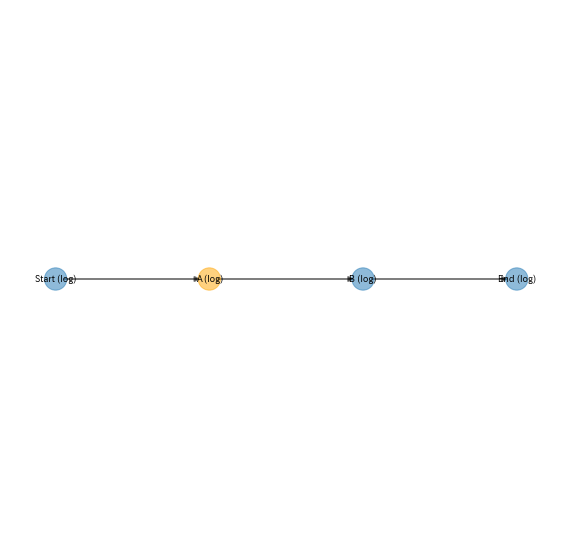

In [1236]:
if __name__ == "__main__":
  # Windowを生成する。
  root = tk.Tk()
  app = Application(master=root)
  # Windowをループさせて、継続的にWindow表示させる。
  app.mainloop()